# DSMarket - Forecasting

## Instalacion de paquetes

In [1]:
#pip install statsmodels
#pip install xgboost

## Importamos librerias necesarias

In [2]:
import pandas as pd
import os
import numpy as np
import statsmodels
import re
import pickle

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Callable, List, Dict, Union

## 1. Cargamos fichero de datos

In [3]:
df = pd.read_parquet("df_forecasting.parquet", engine="fastparquet")
print(df.shape)
print(df.head(3))

(8354260, 14)
                       id              item    category    department  \
0  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
1  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
2  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   

       store store_code  region yearweek  n_sales  revenue  avg_sell_price  \
0  South_End      BOS_1  Boston   201104        0      0.0             NaN   
1  South_End      BOS_1  Boston   201105        0      0.0             NaN   
2  South_End      BOS_1  Boston   201106        0      0.0             NaN   

           event  cluster_store  cluster_item  
0  Without event              2             0  
1      SuperBowl              2             0  
2  Without event              2             0  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   item            object 
 2   category        object 
 3   department      object 
 4   store           object 
 5   store_code      object 
 6   region          object 
 7   yearweek        object 
 8   n_sales         int64  
 9   revenue         float64
 10  avg_sell_price  float64
 11  event           object 
 12  cluster_store   int32  
 13  cluster_item    int32  
dtypes: float64(2), int32(2), int64(1), object(9)
memory usage: 828.6+ MB


In [5]:
series = df["yearweek"].nunique()
print("Cantidad de series temporales: ", series)

Cantidad de series temporales:  274


In [6]:
series = df["id"].nunique()
print("Cantidad de productos: ", series)

Cantidad de productos:  30490


In [7]:
first_week = df["yearweek"].min()
last_week = df["yearweek"].max()
print(f"Semana inicial es {first_week}\nSemana final es {last_week}")

Semana inicial es 201104
Semana final es 201616


## 3. Validacion de nulos

In [8]:
def contar_nulos(*dataframes):
    """
    Cuenta los valores nulos, la cantidad de registros por columna y el porcentaje
    de nulos para cada DataFrame proporcionado.
    """
    for i, df in enumerate(dataframes):
        print(f"\nAnálisis del DataFrame {i+1}:")
        null_counts = df.isnull().sum()
        total_counts = df.shape[0]
        null_percentage = (null_counts / total_counts) * 100

        null_info_df = pd.DataFrame({
            'Cantidad Registros': total_counts,
            'Cantidad Nulos': null_counts,
            '% Nulos': null_percentage
        })

        # Mostrar la información para cada columna
        print(null_info_df[null_info_df['Cantidad Nulos'] > 0])

In [9]:
contar_nulos(df)


Análisis del DataFrame 1:
                Cantidad Registros  Cantidad Nulos    % Nulos
avg_sell_price             8354260         3363362  40.259245


## 4. EDA

### Creacion de fecha para cada semana-año

In [10]:
# Asegurar tipos
df["yearweek"] = df["yearweek"].astype(str)

# Universo de semanas ISO en el rango
weeks_all = sorted(df["yearweek"].unique())
weeks_df = pd.DataFrame(weeks_all, columns=["yearweek"])

# Mapear yearweek → fecha fin de semana (lunes-based ISO) tomamos el lunes de la semana:
def iso_yearweek_to_date(yw):
    year = int(yw[:4]); week = int(yw[4:])
    # ISO: lunes de esa semana
    return pd.to_datetime(f"{year}-W{str(week).zfill(2)}-1", format="%G-W%V-%u")

weeks_df["date"] = weeks_df["yearweek"].map(iso_yearweek_to_date)

In [11]:
weeks_df

,yearweek,date
0,201104,2011-01-24
1,201105,2011-01-31
2,201106,2011-02-07
3,201107,2011-02-14
4,201108,2011-02-21
...,...,...
269,201612,2016-03-21
270,201613,2016-03-28
271,201614,2016-04-04
272,201615,2016-04-11


In [12]:
df = df.merge(weeks_df, on='yearweek', how='left')
df.head(3)

,id,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event,cluster_store,cluster_item,date
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201104,0,0.0,NaN,Without event,2,0,2011-01-24
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,NaN,SuperBowl,2,0,2011-01-31
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,NaN,Without event,2,0,2011-02-07


### EDA total ventas

In [13]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [14]:
y = df.set_index("date").resample("W")["n_sales"].sum()

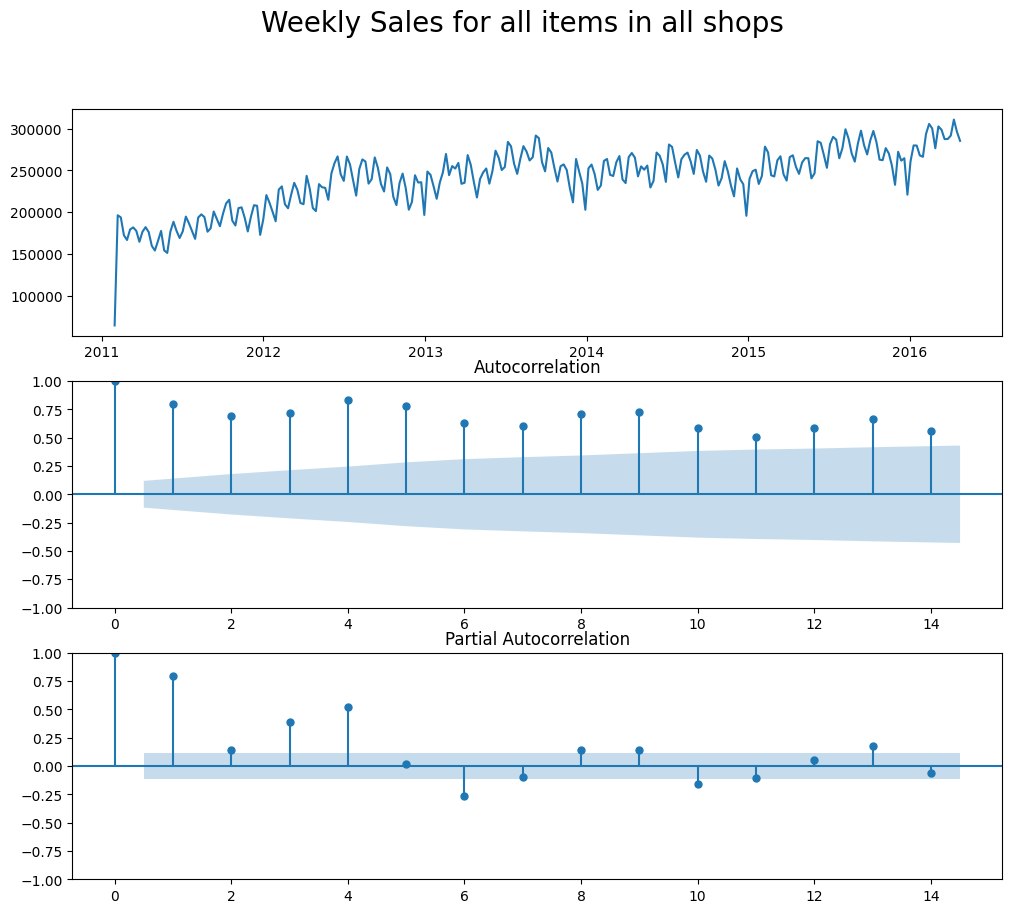

In [15]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

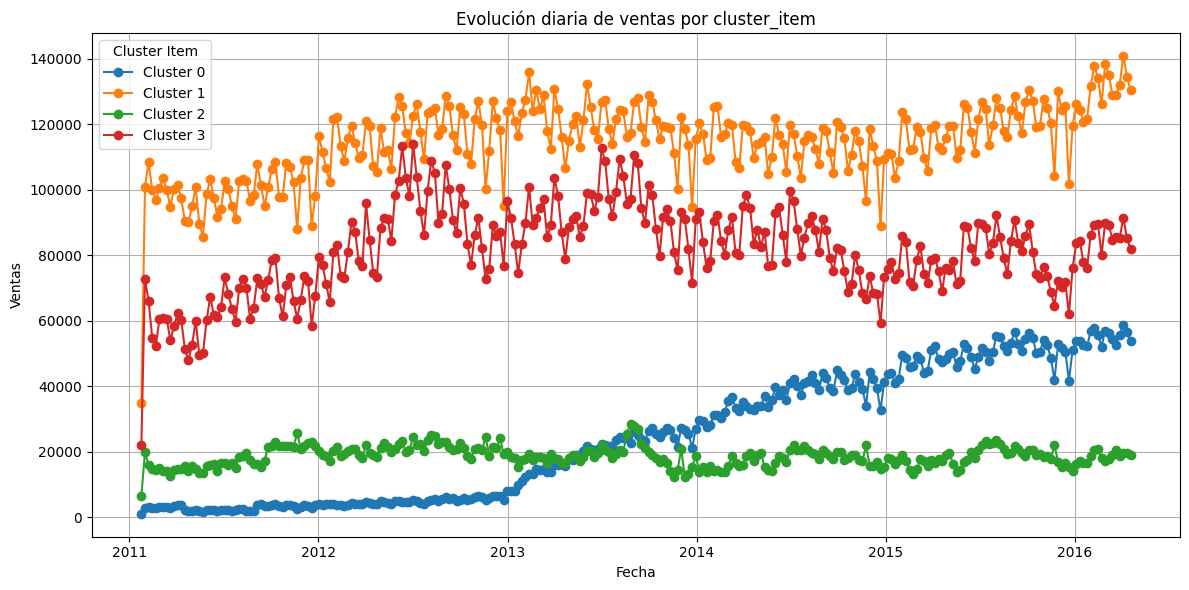

In [16]:

# Asegúrate de que la columna de fecha sea tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupamos las ventas por fecha y cluster_item
df_grouped = df.groupby(['date', 'cluster_item'])['n_sales'].sum().reset_index()

# Creamos el gráfico
plt.figure(figsize=(12, 6))

for cluster in df_grouped['cluster_item'].unique():
    subset = df_grouped[df_grouped['cluster_item'] == cluster]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Cluster {cluster}')

plt.title('Evolución diaria de ventas por cluster_item')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Cluster Item')
plt.grid(True)
plt.tight_layout()
plt.show()

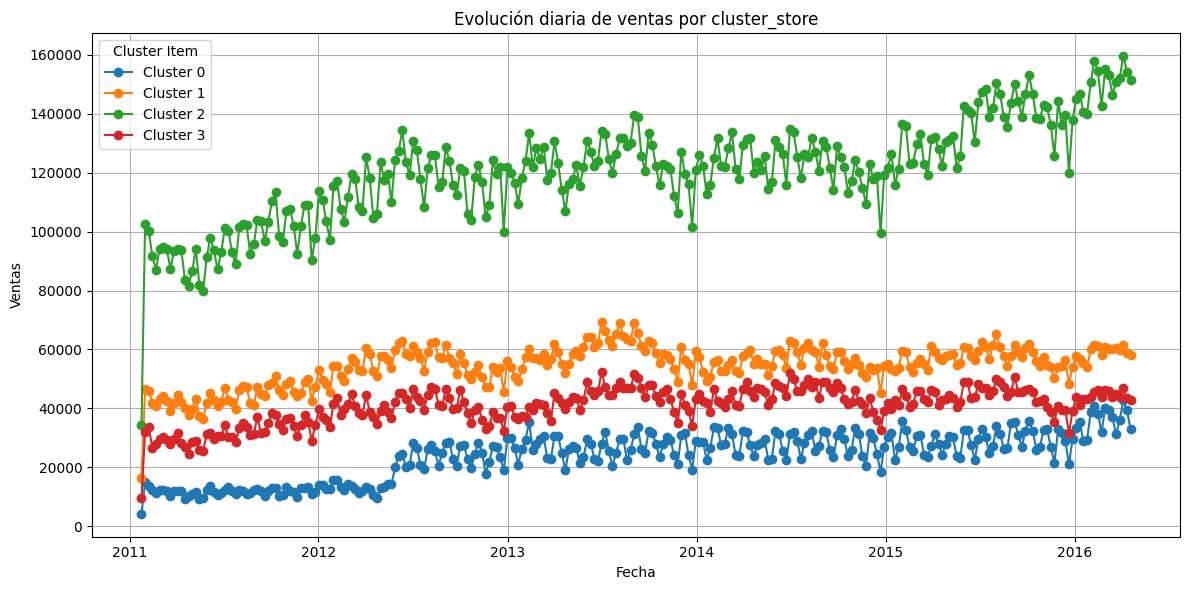

In [17]:
# Asegúrate de que la columna de fecha sea tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupamos las ventas por fecha y cluster_item
df_grouped = df.groupby(['date', 'cluster_store'])['n_sales'].sum().reset_index()

# Creamos el gráfico
plt.figure(figsize=(12, 6))

for cluster in df_grouped['cluster_store'].unique():
    subset = df_grouped[df_grouped['cluster_store'] == cluster]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Cluster {cluster}')

plt.title('Evolución diaria de ventas por cluster_store')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Cluster Item')
plt.grid(True)
plt.tight_layout()
plt.show()

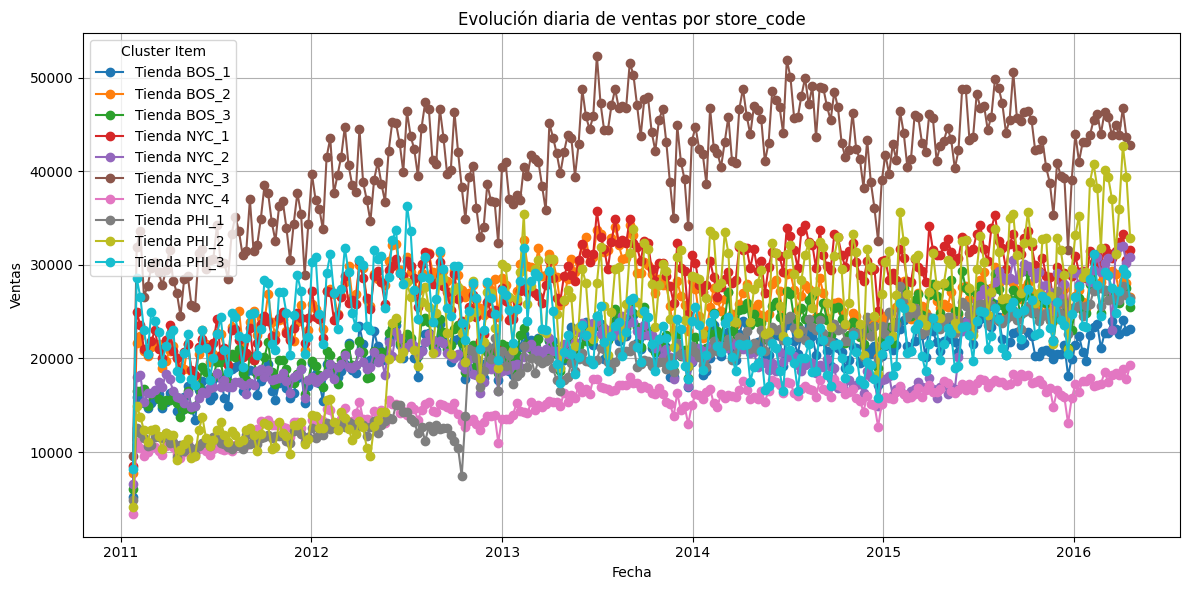

In [18]:
# Asegúrate de que la columna de fecha sea tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupamos las ventas por fecha y cluster_item
df_grouped = df.groupby(['date', 'store_code'])['n_sales'].sum().reset_index()

# Creamos el gráfico
plt.figure(figsize=(12, 6))

for cluster in df_grouped['store_code'].unique():
    subset = df_grouped[df_grouped['store_code'] == cluster]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Tienda {cluster}')

plt.title('Evolución diaria de ventas por store_code')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Cluster Item')
plt.grid(True)
plt.tight_layout()
plt.show()

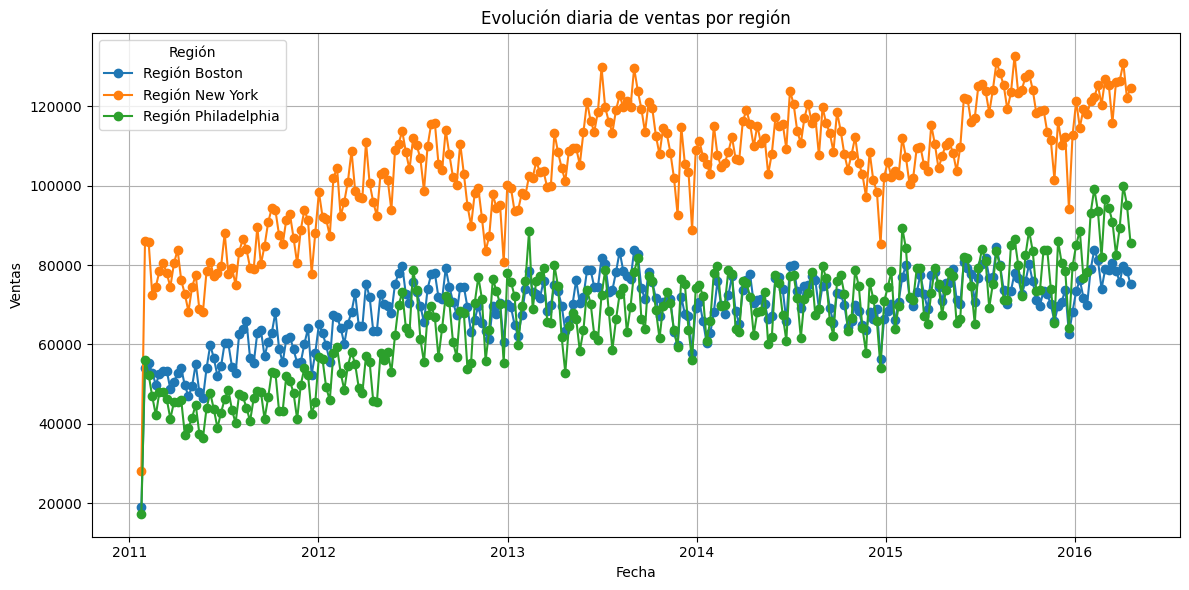

In [19]:

# Asegurarte de que 'date' sea datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar por fecha y región (sumar ventas)
df_grouped = df.groupby(['date', 'region'])['n_sales'].sum().reset_index()

# Crear gráfico
plt.figure(figsize=(12, 6))

for region in df_grouped['region'].unique():
    subset = df_grouped[df_grouped['region'] == region]
    plt.plot(subset['date'], subset['n_sales'], marker='o', label=f'Región {region}')

plt.title('Evolución diaria de ventas por región')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Región')
plt.grid(True)
plt.tight_layout()
plt.show()

### EDA tiendas

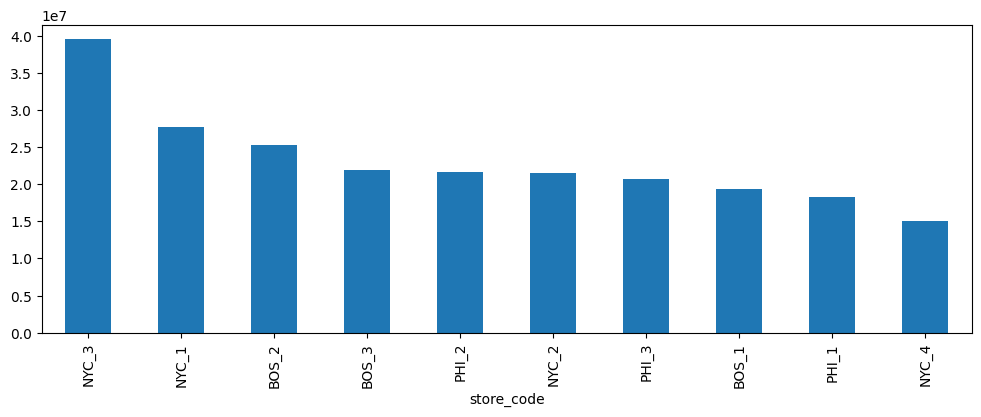

In [20]:
(
    df.
    groupby(["store_code"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### EDA departments

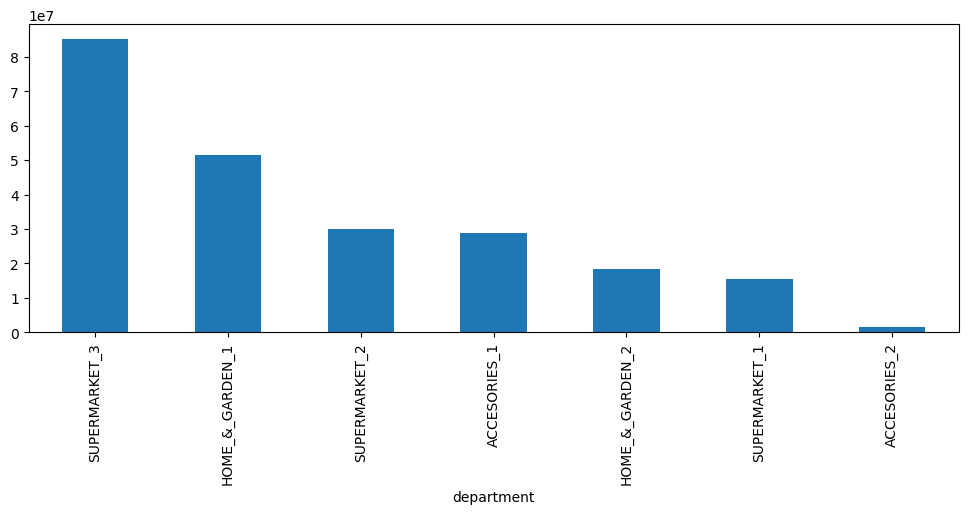

In [21]:
(
    df.
    groupby(["department"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### EDA categories

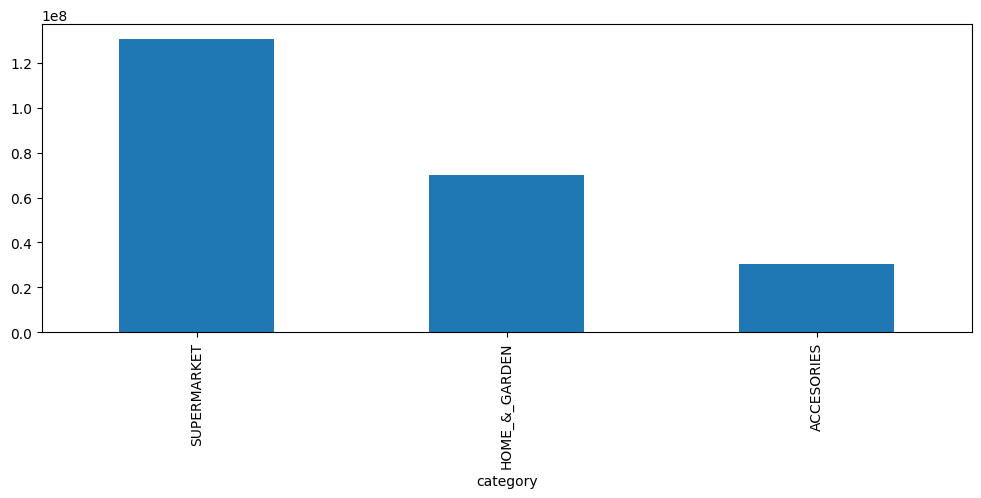

In [22]:
(
    df.
    groupby(["category"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

## 5. Tratamiento variables categoricas

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            object        
 2   category        object        
 3   department      object        
 4   store           object        
 5   store_code      object        
 6   region          object        
 7   yearweek        object        
 8   n_sales         int64         
 9   revenue         float64       
 10  avg_sell_price  float64       
 11  event           object        
 12  cluster_store   int32         
 13  cluster_item    int32         
 14  date            datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(9)
memory usage: 892.3+ MB


In [24]:
df_labels = df[["id", "item", "category", "department", "store", "store_code", "region"]].drop_duplicates().reset_index(drop=True)

Usamos label encoder para asignar un id a cada categoria en variables categoricas

In [25]:
# Columnas categóricas a transformar
cat_cols = ["item", "category", "department", "region", "store_code"]


from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

for col in cat_cols:
    df[col] = enc.fit_transform(df[col])

In [26]:
# columnas categóricas a codificar
#cat_cols = ["item", "category", "department", "region", "store_code", "region"]

# inicializar encoder
#enc = OrdinalEncoder(
#    handle_unknown="use_encoded_value",  # no fallar si aparece categoría nueva en futuros datos
#    unknown_value=-1,
#    dtype=np.int64
#)

# ajustamos y transformamos en el mismo df
#df[cat_cols] = enc.fit_transform(df[cat_cols]) + 1

### Variable 'event'

In [27]:
df["event"].value_counts(normalize=True) * 100

event
Without event        70.437956
SuperBowl             2.189781
Valentine's Day       2.189781
St. Patrick's Day     2.189781
Easter                2.189781
Mother's Day          1.824818
Independence Day      1.824818
Ramadan starts        1.824818
Labor Day             1.824818
Green Monday          1.824818
Halloween             1.824818
Thanksgiving          1.824818
Cyber Monday          1.824818
NewYear               1.824818
Father's Day          1.459854
Super Saturday        1.459854
Christmas Day         1.459854
Name: proportion, dtype: float64

In [28]:
df["event"] = np.where(df["event"] == "Without event", 0, 1)

In [29]:
df["event"].value_counts(normalize=True) * 100

event
0    70.437956
1    29.562044
Name: proportion, dtype: float64

In [30]:
df

,id,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event,cluster_store,cluster_item,date
0,ACCESORIES_1_001_BOS_1,0,0,0,South_End,0,0,201104,0,0.0,NaN,0,2,0,2011-01-24
1,ACCESORIES_1_001_BOS_1,0,0,0,South_End,0,0,201105,0,0.0,NaN,1,2,0,2011-01-31
2,ACCESORIES_1_001_BOS_1,0,0,0,South_End,0,0,201106,0,0.0,NaN,0,2,0,2011-02-07
3,ACCESORIES_1_001_BOS_1,0,0,0,South_End,0,0,201107,0,0.0,NaN,1,2,0,2011-02-14
4,ACCESORIES_1_001_BOS_1,0,0,0,South_End,0,0,201108,0,0.0,NaN,0,2,0,2011-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354255,SUPERMARKET_3_827_PHI_3,3048,2,6,Queen_Village,9,2,201612,17,20.4,1.2,1,2,0,2016-03-21
8354256,SUPERMARKET_3_827_PHI_3,3048,2,6,Queen_Village,9,2,201613,22,26.4,1.2,0,2,0,2016-03-28
8354257,SUPERMARKET_3_827_PHI_3,3048,2,6,Queen_Village,9,2,201614,8,9.6,1.2,0,2,0,2016-04-04
8354258,SUPERMARKET_3_827_PHI_3,3048,2,6,Queen_Village,9,2,201615,0,0.0,NaN,0,2,0,2016-04-11


In [31]:
cols_order = [
    "id", "item", "category", "department", "store_code", "region",
    "yearweek", "date", "event", "cluster_item", "cluster_store", "n_sales", "revenue", "avg_sell_price"
]

df = df[cols_order]

In [32]:
df.head(5)

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,cluster_store,n_sales,revenue,avg_sell_price
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,2011-01-24,0,0,2,0,0.0,NaN
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,2011-01-31,1,0,2,0,0.0,NaN
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,2011-02-07,0,0,2,0,0.0,NaN
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,2011-02-14,1,0,2,0,0.0,NaN
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,2011-02-21,0,0,2,0,0.0,NaN


Anadimos la variable semana del mes

In [33]:
# Si tu columna de fecha no está en datetime
df['date'] = pd.to_datetime(df['date'])

# Crear variable de mes y año (por si luego quieres agrupar)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Calcular la "semana del mes"
df['week_of_month'] = df['date'].apply(lambda d: (d.day - 1) // 7 + 1)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_17324\4184934613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


<Axes: xlabel='week_of_month'>

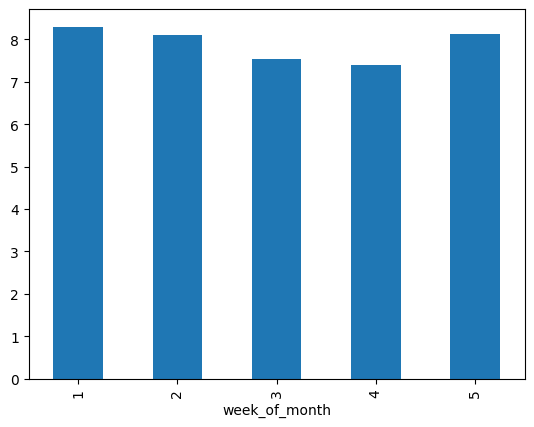

In [34]:
df.groupby('week_of_month')['n_sales'].mean().plot(kind='bar')

In [35]:
df = df.drop(columns=["week_of_month", "month"])

## 6. Creacion dataframe a predecir

In [36]:
def future_yearweeks_df(last_week, weeks_predict: int, as_str: bool = True) -> pd.DataFrame:
    """
    Genera un DataFrame con las próximas `weeks_predict` semanas a partir de `last_week`.
    - last_week: 'YYYYWW' como str o int (p.ej. '201617' o 201617)
    - weeks_predict: cantidad de semanas futuras a generar
    - as_str: True => yearweek como string 'YYYYWW'; False => int
    """
    last_week = str(last_week)
    year = int(last_week[:4])
    week = int(last_week[4:])

    weeks = []
    for _ in range(weeks_predict):
        week += 1
        if week > 53:  # si llegara a existir W53, pasamos a W01 del año siguiente
            week = 1
            year += 1
        val = f"{year}{str(week).zfill(2)}"
        weeks.append(val if as_str else int(val))

    return pd.DataFrame({"yearweek": weeks})

### Determinar numero semanas a predecir

In [37]:
weeks_predict = 4
df_weeks_future = future_yearweeks_df(last_week, weeks_predict, as_str=True)

# Crear dataframe de ids únicos
df_ids = df[["id", "item", "category", "department", "store_code","region"]].drop_duplicates()

# Cross join de id's y semanas a predecir, obteniendo df_predict
try:
    # pandas 1.2+ soporta how='cross'
    df_predict = df_ids.merge(df_weeks_future, how="cross")
except TypeError:
    # fallback si tu pandas no soporta 'cross'
    df_ids["_k"] = 1
    df_weeks_future["_k"] = 1
    df_predict = df_ids.merge(df_weeks_future, on="_k").drop(columns="_k")

# df_predict tiene columnas: id, yearweek, n_sales
print(df_predict.shape)
df_predict.head()

(121960, 7)


,id,item,category,department,store_code,region,yearweek
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201617
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201618
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201619
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201620
4,ACCESORIES_1_001_BOS_2,0,0,0,1,0,201617


### Asignar fecha a las nuevas semanas

In [38]:
# Asegurar tipos
df_predict["yearweek"] = df_predict["yearweek"].astype(str)

# Universo de semanas ISO en el rango
weeks_predict_all = sorted(df_predict["yearweek"].unique())
weeks_df_predict = pd.DataFrame(weeks_predict_all, columns=["yearweek"])

# Mapear yearweek → fecha fin de semana (lunes-based ISO) tomamos el lunes de la semana:
def iso_yearweek_to_date(yw):
    year = int(yw[:4]); week = int(yw[4:])
    # ISO: lunes de esa semana
    return pd.to_datetime(f"{year}-W{str(week).zfill(2)}-1", format="%G-W%V-%u")

weeks_df_predict["date"] = weeks_df_predict["yearweek"].map(iso_yearweek_to_date)

In [39]:
df_predict = df_predict.merge(weeks_df_predict, on='yearweek', how='left')
df_predict.head(3)

,id,item,category,department,store_code,region,yearweek,date
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201617,2016-04-25
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201618,2016-05-02
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201619,2016-05-09


In [40]:
df_predict.shape

(121960, 8)

Guardamos el numero de semana de los registros a predecir para la prediccion final.

In [41]:
predict_yearweek = df_predict[['yearweek']].copy()

In [42]:
predict_yearweek["unique_id"] = df_predict.index

In [43]:
predict_yearweek

,yearweek,unique_id
0,201617,0
1,201618,1
2,201619,2
3,201620,3
4,201617,4
...,...,...
121955,201620,121955
121956,201617,121956
121957,201618,121957
121958,201619,121958


### Adicion de variables para las futuras semanas

In [44]:
df_predict["event"] = 0
df_predict["n_sales"] = 0
df_predict["revenue"] = 0
df_predict["year"] = 2016
df_predict["avg_sell_price"] = np.nan

In [45]:
cluster_store = df[["store_code", "cluster_store"]].drop_duplicates()
cluster_item = df[["item", "cluster_item"]].drop_duplicates()

In [46]:
df_predict.shape

(121960, 13)

In [47]:
df_predict = (
    df_predict
    .merge(cluster_store, on="store_code", how="left")
    .merge(cluster_item, on="item", how="left")
)

In [48]:
df_predict.shape

(121960, 15)

In [49]:
df.head(3)

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,cluster_store,n_sales,revenue,avg_sell_price,year
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,2011-01-24,0,0,2,0,0.0,NaN,2011
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,2011-01-31,1,0,2,0,0.0,NaN,2011
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,2011-02-07,0,0,2,0,0.0,NaN,2011


In [50]:
df_predict.head(3)

,id,item,category,department,store_code,region,yearweek,date,event,n_sales,revenue,year,avg_sell_price,cluster_store,cluster_item
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201617,2016-04-25,0,0,0,2016,NaN,2,0
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201618,2016-05-02,0,0,0,2016,NaN,2,0
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201619,2016-05-09,0,0,0,2016,NaN,2,0


In [51]:
df["yearweek"] = df["yearweek"].astype(int)
df_predict["yearweek"] = df_predict["yearweek"].astype(int)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            int64         
 2   category        int64         
 3   department      int64         
 4   store_code      int64         
 5   region          int64         
 6   yearweek        int64         
 7   date            datetime64[ns]
 8   event           int64         
 9   cluster_item    int32         
 10  cluster_store   int32         
 11  n_sales         int64         
 12  revenue         float64       
 13  avg_sell_price  float64       
 14  year            int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(8), object(1)
memory usage: 860.5+ MB


In [53]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121960 entries, 0 to 121959
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              121960 non-null  object        
 1   item            121960 non-null  int64         
 2   category        121960 non-null  int64         
 3   department      121960 non-null  int64         
 4   store_code      121960 non-null  int64         
 5   region          121960 non-null  int64         
 6   yearweek        121960 non-null  int64         
 7   date            121960 non-null  datetime64[ns]
 8   event           121960 non-null  int64         
 9   n_sales         121960 non-null  int64         
 10  revenue         121960 non-null  int64         
 11  year            121960 non-null  int64         
 12  avg_sell_price  0 non-null       float64       
 13  cluster_store   121960 non-null  int32         
 14  cluster_item    121960 non-null  int

### Union de df historico y df a predecir

In [54]:
rows_df = df.shape[0]
rows_predict = df_predict.shape[0]
total_rows = rows_df + rows_predict
print(f"Filas en df historico: {rows_df}")
print(f"Filas en df predecir: {rows_predict}")
print(f"Filas que deben resultar despues de union: {total_rows}")

Filas en df historico: 8354260
Filas en df predecir: 121960
Filas que deben resultar despues de union: 8476220


In [55]:
df = pd.concat([df, df_predict], ignore_index=True)

In [56]:
rows_df_concat = df.shape[0]
rows_validation = total_rows - rows_df_concat
print(f"Filas en df historico: {rows_df}")
print(f"Filas en df predecir: {rows_predict}")
print(f"Filas que deben resultar despues de union: {total_rows}")
print(f"Filas resultantes despues de union: {rows_df_concat}")
print(f"Diferencia de: {rows_validation}")

Filas en df historico: 8354260
Filas en df predecir: 121960
Filas que deben resultar despues de union: 8476220
Filas resultantes despues de union: 8476220
Diferencia de: 0


Corrección nulos precio

In [57]:
df['avg_sell_price'] = (
    df.sort_values(['id','date'])
      .groupby('id')['avg_sell_price']
      .transform('ffill')
      .reindex(df.index)   # re-alinea al índice original
)

In [58]:
df.tail(5)

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,cluster_store,n_sales,revenue,avg_sell_price,year
8476215,SUPERMARKET_3_827_PHI_2,3048,2,6,8,2,201620,2016-05-16,0,0,0,0,0.0,1.2,2016
8476216,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201617,2016-04-25,0,0,2,0,0.0,1.2,2016
8476217,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201618,2016-05-02,0,0,2,0,0.0,1.2,2016
8476218,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201619,2016-05-09,0,0,2,0,0.0,1.2,2016
8476219,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201620,2016-05-16,0,0,2,0,0.0,1.2,2016


Hacemos copia para usar al fianal

In [59]:
df_copy = df.copy()

Creación diferencia - eliminar estacionalidad

In [60]:
df_ventas_origen = df[["date", "id", "n_sales", "yearweek", "avg_sell_price"]]

In [61]:
df = df.sort_values(['id', 'date'])

# Diferencia mensual por producto: y_t - y_{t-1}
df["monthly_sales_diff"] = df.groupby("id")["n_sales"].diff(1)

In [62]:
df = df.drop(columns="n_sales")

In [63]:
df["n_sales"] = df["monthly_sales_diff"]

In [64]:
df = df.drop(columns="monthly_sales_diff")

In [65]:
df = df.dropna(subset="n_sales")

Creación semana sin y  cos

In [66]:
df["yearweek"]

1          201105
2          201106
3          201107
4          201108
5          201109
            ...  
8354259    201616
8476216    201617
8476217    201618
8476218    201619
8476219    201620
Name: yearweek, Length: 8445730, dtype: int64

In [67]:
# Asegurar que sea string
df["yearweek"] = df["yearweek"].astype(str)

# Separar: 4 primeros dígitos = año, el resto = semana
df["year"] = df["yearweek"].str[:4].astype(int)
df["week"] = df["yearweek"].str[4:].astype(int)


In [68]:
df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)

In [69]:
df.isnull().sum()

id                      0
item                    0
category                0
department              0
store_code              0
region                  0
yearweek                0
date                    0
event                   0
cluster_item            0
cluster_store           0
revenue                 0
avg_sell_price    1753491
year                    0
n_sales                 0
week                    0
week_sin                0
week_cos                0
dtype: int64

## 7. Creacion de features para time series

In [70]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, nr_lags):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column, agg_func_name])

    # 1) Agregar a nivel semanal (date ya corresponde al lunes ISO)
    gb_df_ = (
        df.groupby(gb_list + ["date"], as_index=False)[target_column]
          .agg(agg_func)
          .rename(columns={target_column: new_name})
          .sort_values(gb_list + ["date"])
    )

    # 2) Crear lags semanales por cada grupo
    for lag in range(1, nr_lags + 1):
        gb_df_[f"{new_name}_lag{lag}"] = (
            gb_df_.groupby(gb_list, sort=False)[new_name].shift(lag)
        )

    # 4) Evitar target leakage
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(columns=[new_name], inplace=True)

    return gb_df_

In [71]:
def _resolve_agg_func(agg_func: Union[str, Callable]) -> Union[str, Callable]:
    if isinstance(agg_func, str):
        return agg_func.lower()  # "sum", "mean", etc.
    if callable(agg_func):
        # 🔽 Mapea np.sum → "sum", np.mean → "mean", etc.
        lut = {"sum": "sum", "mean": "mean", "max": "max", "min": "min", "median": "median"}
        name = getattr(agg_func, "__name__", "")
        if name in lut:
            return lut[name]
        return agg_func  # callables raros se devuelven tal cual
    raise ValueError(f"agg_func inválido: {agg_func}")

def _resolve_agg_name(agg_func: Union[str, Callable], agg_func_name: str) -> str:
    if agg_func_name:
        return agg_func_name
    if isinstance(agg_func, str):
        return agg_func.lower()
    if callable(agg_func) and getattr(agg_func, "__name__", None):
        return agg_func.__name__.lower()
    return "agg"

def generate_and_merge_features(
    df: pd.DataFrame,
    specs: List[Dict],
    *,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    specs: lista de diccionarios con llaves:
      - gb_list: List[str]
      - target_column: str
      - agg_func: str | Callable
      - agg_func_name: str (opcional; si vacío se infiere)
      - nr_lags: int
    Retorna df base + todas las columnas de lags generadas en specs.
    """
    base = df.copy()

    for i, spec in enumerate(specs, start=1):
        gb_list        = spec["gb_list"]
        target_column  = spec["target_column"]
        agg_func       = _resolve_agg_func(spec["agg_func"])
        agg_func_name  = _resolve_agg_name(spec["agg_func"], spec.get("agg_func_name", ""))
        nr_lags        = int(spec["nr_lags"])

        # construir feature table con tu función base (sin resample)
        feats = build_ts_vars(
            df=base,
            gb_list=gb_list,
            target_column=target_column,
            agg_func=agg_func,
            agg_func_name=agg_func_name,
            nr_lags=nr_lags,
        )
        # claves de unión para este feature set
        on_keys = gb_list + ["date"]

        if verbose:
            created_cols = [c for c in feats.columns if c.endswith(tuple([f"_lag{k}" for k in range(1, nr_lags+1)]))]
            print(f"[{i}/{len(specs)}] Merge on {on_keys} | new cols: {created_cols[:5]}{' ...' if len(created_cols)>5 else ''}")

        # merge left al df base
        base = base.merge(feats, on=on_keys, how="left")

    return base


#### Configuracion de features

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8445730 entries, 1 to 8476219
Data columns (total 18 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            int64         
 2   category        int64         
 3   department      int64         
 4   store_code      int64         
 5   region          int64         
 6   yearweek        object        
 7   date            datetime64[ns]
 8   event           int64         
 9   cluster_item    int32         
 10  cluster_store   int32         
 11  revenue         float64       
 12  avg_sell_price  float64       
 13  year            int64         
 14  n_sales         float64       
 15  week            int64         
 16  week_sin        float64       
 17  week_cos        float64       
dtypes: datetime64[ns](1), float64(5), int32(2), int64(8), object(2)
memory usage: 1.1+ GB


Benchmark:
1. Store_code/Revenue/sum/l=5 - store_code,department/n_sales/mean/l=4 --> RMSE 18.94

In [73]:
df

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,cluster_store,revenue,avg_sell_price,year,n_sales,week,week_sin,week_cos
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,2011-01-31,1,0,2,0.0,NaN,2011,0.0,5,0.568065,0.822984
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,2011-02-07,0,0,2,0.0,NaN,2011,0.0,6,0.663123,0.748511
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,2011-02-14,1,0,2,0.0,NaN,2011,0.0,7,0.748511,0.663123
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,2011-02-21,0,0,2,0.0,NaN,2011,0.0,8,0.822984,0.568065
5,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201109,2011-02-28,0,0,2,0.0,NaN,2011,0.0,9,0.885456,0.464723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354259,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201616,2016-04-18,0,0,2,0.0,1.2,2016,0.0,16,0.935016,-0.354605
8476216,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201617,2016-04-25,0,0,2,0.0,1.2,2016,0.0,17,0.885456,-0.464723
8476217,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201618,2016-05-02,0,0,2,0.0,1.2,2016,0.0,18,0.822984,-0.568065
8476218,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201619,2016-05-09,0,0,2,0.0,1.2,2016,0.0,19,0.748511,-0.663123


In [74]:
features = [
    {
        "gb_list": ["item"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",  # se inferirá el mismo nombre de la funcion si no se diligencia
        "nr_lags": 4,
    },
    {
        "gb_list": ["item"],
        "target_column": "n_sales",
        "agg_func": "mean",
        "agg_func_name": "",  # se inferirá el mismo nombre de la funcion si no se diligencia
        "nr_lags": 4,
    },
    {
        "gb_list": ["region"],
        "target_column": "n_sales",
        "agg_func": "mean",
        "agg_func_name": "",  # se inferirá el mismo nombre de la funcion si no se diligencia
        "nr_lags": 4,
    },
    {
        "gb_list": ["item", "store_code"],
        "target_column": "revenue",
        "agg_func": "mean",
        "agg_func_name": "",  # se inferirá el mismo nombre de la funcion si no se diligencia
        "nr_lags": 4,
    },
    {
        "gb_list": ["store_code", "item"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",
        "nr_lags": 12,
    },
    {
        "gb_list": ["department", "store_code"],
        "target_column": "n_sales",
        "agg_func": "max",
        "agg_func_name": "",
        "nr_lags": 4,
    },
    {
        "gb_list": ["region", "store_code"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",
        "nr_lags": 4,
    }
]

In [75]:
df_features = generate_and_merge_features(df, features, verbose=True)
df_col = df.shape[1]
df_feat_col = df_features.shape[1]
dif_cols = df_feat_col-df_col
print(f"Se han creado {dif_cols} nuevas variables")

Dropping columns that might cause target leakage item_n_sales_sum
[1/7] Merge on ['item', 'date'] | new cols: ['item_n_sales_sum_lag1', 'item_n_sales_sum_lag2', 'item_n_sales_sum_lag3', 'item_n_sales_sum_lag4']
Dropping columns that might cause target leakage item_n_sales_mean
[2/7] Merge on ['item', 'date'] | new cols: ['item_n_sales_mean_lag1', 'item_n_sales_mean_lag2', 'item_n_sales_mean_lag3', 'item_n_sales_mean_lag4']
Dropping columns that might cause target leakage region_n_sales_mean
[3/7] Merge on ['region', 'date'] | new cols: ['region_n_sales_mean_lag1', 'region_n_sales_mean_lag2', 'region_n_sales_mean_lag3', 'region_n_sales_mean_lag4']
Dropping columns that might cause target leakage item_store_code_revenue_mean
[4/7] Merge on ['item', 'store_code', 'date'] | new cols: ['item_store_code_revenue_mean_lag1', 'item_store_code_revenue_mean_lag2', 'item_store_code_revenue_mean_lag3', 'item_store_code_revenue_mean_lag4']
Dropping columns that might cause target leakage store_code_

# Nuevas funciones

In [76]:
def add_shift_ratio_features_with_shifts(
    df: pd.DataFrame,
    target_column: str,
    group_col: str = "unique_id"
) -> None:
    """
    Agrega al DataFrame:
    - columnas con shift(52), shift(53), shift(54)
    - ratios entre target y esos shifts

    Todo agrupado por group_col (por defecto: "unique_id"), y modificado in-place.
    """

    df.sort_values([group_col, "date"], inplace=True)

    # Crear columnas intermedias de shift
    df[f"{target_column}_shift52"] = (
        df.groupby(group_col)[target_column].transform(lambda x: x.shift(52))
    )
    df[f"{target_column}_shift26"] = (
        df.groupby(group_col)[target_column].transform(lambda x: x.shift(26))
    )
    
    # Crear ratios
    df[f"{target_column}_vs_shift52"] = (
        df[target_column] / df[f"{target_column}_shift52"]
    )

    df[f"{target_column}_vs_shift26"] = (
        df[target_column] / df[f"{target_column}_shift26"]
    )

In [77]:
import pandas as pd

def add_rolling_feature_inplace(
    df: pd.DataFrame,
    target_column: str,
    groupby_cols,
    window: int = 52,
    agg_func: str = "mean",
    n_lags: int = 0,
    new_column_name: str = None
) -> None:
    """
    Añade una feature de ventana móvil (rolling) agrupada y sus lags, modificando el DataFrame in-place.

    Parámetros:
    - df: DataFrame de entrada
    - target_column: columna sobre la que se aplica el rolling
    - groupby_cols: str o lista de columnas por las que agrupar
    - window: tamaño de la ventana rolling
    - agg_func: función a aplicar: "mean", "sum", "std", "min", "max"
    - n_lags: número de lags a crear a partir del rolling
    - new_column_name: nombre base de la nueva columna (opcional)
    """

    if isinstance(groupby_cols, str):
        groupby_cols = [groupby_cols]

    if new_column_name is None:
        new_column_name = f"{'_'.join(groupby_cols)}_{target_column}_roll{window}_{agg_func}"

    # Ordenar para el cálculo correcto
    df.sort_values(groupby_cols + ["date"], inplace=True)

    # Calcular rolling
    df[new_column_name] = (
        df.groupby(groupby_cols)[target_column]
          .transform(lambda x: x.rolling(window=window, min_periods=window)
                                .__getattribute__(agg_func)())
    )

    # Crear lags si se solicita
    if n_lags > 0:
        for lag in range(1, n_lags + 1):
            lag_col = f"{new_column_name}_lag{lag}"
            df[lag_col] = (
                df.groupby(groupby_cols)[new_column_name]
                  .shift(lag)
            )

        # Eliminar la columna rolling original
        df.drop(columns=[new_column_name], inplace=True)

In [78]:
from typing import Union, Sequence, Optional
import pandas as pd

def add_rolling_quantile_inplace(
    df: pd.DataFrame,
    target_column: str,
    groupby_cols: Union[str, Sequence[str]],
    window: int = 3,
    q: Union[float, Sequence[float]] = 0.5,
    interpolation: str = "linear",
    min_periods: Optional[int] = None,
    n_lags: int = 0,
    new_column_name: Optional[str] = None,
) -> None:
    """
    Añade cuantiles rolling agrupados sobre `target_column`, genera sus lags y
    modifica `df` in-place. Las columnas de cuantiles intermedias se eliminan al final.

    Parámetros:
    - df: DataFrame de entrada (debe tener columna 'date' ordenable).
    - target_column: columna numérica sobre la que calcular el rolling quantile.
    - groupby_cols: columna(s) por las que agrupar (str o lista).
    - window: tamaño de la ventana rolling.
    - q: cuantíl o lista de cuantiles en [0, 1] (p.ej. 0.25, [0.25, 0.5, 0.75]).
    - interpolation: método de interpolación para quantile (p.ej. "linear").
    - min_periods: mínimos periodos para calcular (por defecto = window).
    - n_lags: número de lags a generar para cada cuantíl calculado.
    - new_column_name: nombre de la nueva columna (solo válido si q es escalar).
    """

    if isinstance(groupby_cols, str):
        groupby_cols = [groupby_cols]

    if min_periods is None:
        min_periods = window

    # Normaliza q a lista
    q_list = list(q) if isinstance(q, (list, tuple)) else [q]

    # Validaciones
    for qi in q_list:
        if not (0.0 <= float(qi) <= 1.0):
            raise ValueError(f"Cada q debe estar entre 0 y 1. Recibido: {qi}")

    if new_column_name is not None and len(q_list) != 1:
        raise ValueError("`new_column_name` solo se permite cuando `q` es escalar.")

    # Orden por grupo y fecha
    df.sort_values(groupby_cols + ["date"], inplace=True)

    # Definición del nombre base para los cuantiles
    def _default_col_name(qi: float) -> str:
        q_str = f"{qi:.3f}".rstrip("0").rstrip(".")
        return f"{'_'.join(groupby_cols)}_{target_column}_roll{window}_q{q_str}"

    grp = df.groupby(groupby_cols, sort=False)[target_column]
    temp_cols = []  # Para luego eliminar las columnas temporales

    # 1️⃣ Crear columnas de cuantiles rolling
    for qi in q_list:
        col = new_column_name if (new_column_name and len(q_list) == 1) else _default_col_name(qi)
        df[col] = grp.transform(
            lambda s: pd.to_numeric(s, errors="coerce")
                        .rolling(window=window, min_periods=min_periods)
                        .quantile(q=qi, interpolation=interpolation)
        )
        temp_cols.append(col)

    # 2️⃣ Crear columnas de lags
    if n_lags > 0:
        for col in temp_cols:
            for lag in range(1, n_lags + 1):
                lag_col = f"{col}_lag{lag}"
                df[lag_col] = df.groupby(groupby_cols, sort=False)[col].shift(lag)

    # 3️⃣ Eliminar columnas temporales de cuantiles (si se crearon)
    df.drop(columns=temp_cols, inplace=True)

# Nuevas Features

In [79]:
quantiles = [0.1, 0.5, 0.9]

## ventas últimos 26 semanas

### Por unique_id

In [80]:
add_rolling_feature_inplace(
    df_features,
    target_column = "n_sales",
    groupby_cols = "id",
    window = 4,
    agg_func = "mean",
    n_lags = 1
)

In [81]:
add_rolling_quantile_inplace(
    df_features,
    target_column= "n_sales",
    groupby_cols = "id",
    window = 4,
    q= quantiles,
    n_lags = 1
)

In [82]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "id",
#    window = 4,
#    agg_func = "max",
#    n_lags = 1
# )

In [83]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "id",
#    window = 4,
#    agg_func = "min",
#    n_lags = 1
# )

In [84]:
add_rolling_feature_inplace(
   df_features,
   target_column = "n_sales",
   groupby_cols = "id",
   window = 4,
   agg_func = "std",
   n_lags = 1
)

In [85]:
# add_rolling_feature_inplace(
#     df_features,
#     target_column = "n_sales",
#     groupby_cols = "id",
#     window = 3,
#     agg_func = "mean",
#     n_lags = 1
# )

In [86]:
# add_rolling_quantile_inplace(
#     df_features,
#     target_column= "n_sales",
#     groupby_cols = "id",
#     window = 3,
#     q= quantiles,
#     n_lags = 1
# )

In [87]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "id",
#    window = 3,
#    agg_func = "max",
#    n_lags = 1
# )

In [88]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "id",
#    window = 3,
#    agg_func = "min",
#    n_lags = 1
# )

In [89]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "id",
#    window = 3,
#    agg_func = "std",
#    n_lags = 1
# )

Por cluster

In [90]:
add_rolling_feature_inplace(
    df_features,
    target_column = "n_sales",
    groupby_cols = "cluster_item",
    window = 4,
    agg_func = "mean",
    n_lags = 1
)

In [91]:
# add_rolling_quantile_inplace(
#     df_features,
#     target_column= "n_sales",
#     groupby_cols = "cluster_item",
#     window = 4,
#     q= quantiles,
#     n_lags = 1
# )

In [92]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "cluster_item",
#    window = 4,
#    agg_func = "max",
#    n_lags = 1
# )

In [93]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "cluster_item",
#    window = 4,
#    agg_func = "min",
#    n_lags = 1
# )

In [94]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "cluster_item",
#    window = 4,
#    agg_func = "std",
#    n_lags = 1
# )

### Por ventas tienda

In [95]:
# add_rolling_feature_inplace(
#     df_features,
#     target_column = "n_sales",
#     groupby_cols = ["department","store_code"],
#     window = 4,
#     agg_func = "mean",
#     n_lags = 1
# )

In [96]:
# add_rolling_feature_inplace(
#     df_features,
#     target_column = "n_sales",
#     groupby_cols = ["department","store_code"],
#     window = 4,
#     agg_func = "max",
#     n_lags = 1
# )

In [97]:
# add_rolling_quantile_inplace(
#     df_features,
#     target_column= "n_sales",
#     groupby_cols = "store_code",
#     window = 4,
#     q= quantiles,
#     n_lags = 1
# )

In [98]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "store_code",
#    window = 4,
#    agg_func = "max",
#    n_lags = 1
# )

In [99]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "store_code",
#    window = 4,
#    agg_func = "min",
#    n_lags = 1
# )

In [100]:
# add_rolling_feature_inplace(
#    df_features,
#    target_column = "n_sales",
#    groupby_cols = "store_code",
#    window = 4,
#    agg_func = "std",
#    n_lags = 1
# )

## 8. Split Train, Test y Predict

In [101]:
# df_features['random_feature'] = np.random.rand(len(df_features))

In [102]:
from sklearn.preprocessing import OrdinalEncoder

# Asegurarte de que sea string
df_features["yearweek"] = df_features["yearweek"].astype(str)

# Crear el encoder
encoder = OrdinalEncoder()

# Ajustar y transformar
df_features["yearweek_encoded"] = encoder.fit_transform(df_features[["yearweek"]])

# Verificar
print(df_features[["yearweek", "yearweek_encoded"]].head())

     yearweek  yearweek_encoded
0      201105               0.0
277    201105               0.0
554    201105               0.0
831    201105               0.0
1108   201105               0.0


In [103]:
df_features.set_index(["yearweek", "id"], inplace=True)

In [104]:
# df_features.drop(columns=["year"], inplace=True)

# df_features.drop(columns=[     "store_code",
#     "store_code_item_n_sales_sum_lag7",
#     "event",
#     "store_code_item_n_sales_sum_lag5",
#     "id_n_sales_roll4_q0.5_lag1",
#     "store_code_item_n_sales_sum_lag6",
#     "store_code_item_n_sales_sum_lag12",
#     "store_code_item_n_sales_sum_lag11",
#     "store_code_item_n_sales_sum_lag8",
#     "store_code_item_n_sales_sum_lag3",
#     "department",
#     "store_code_item_n_sales_sum_lag10"], inplace=True)

In [105]:
# df_features.drop(columns=[ 'department', 'store_code', 'year', 'item_n_sales_sum_lag2', 'item_n_sales_sum_lag3', 'item_n_sales_mean_lag1', 'item_n_sales_mean_lag2', 'item_n_sales_mean_lag3', 'item_n_sales_mean_lag4', 'region_n_sales_mean_lag1', 'region_n_sales_mean_lag2', 'region_n_sales_mean_lag3', 'region_n_sales_mean_lag4', 'store_code_item_n_sales_sum_lag5', 'store_code_item_n_sales_sum_lag6', 'store_code_item_n_sales_sum_lag7', 'store_code_item_n_sales_sum_lag8', 'store_code_item_n_sales_sum_lag9', 'store_code_item_n_sales_sum_lag10', 'store_code_item_n_sales_sum_lag11', 'store_code_item_n_sales_sum_lag12', 'department_store_code_n_sales_max_lag3', 'region_store_code_n_sales_sum_lag1', 'region_store_code_n_sales_sum_lag3', 'region_store_code_n_sales_sum_lag4', 'id_n_sales_roll4_q0.5_lag1', 'id_n_sales_roll3_q0.5_lag1', 'id_n_sales_roll3_min_lag1', 'store_code_n_sales_roll4_max_lag1', 'random_feature' 
# ], inplace=True)

In [106]:
df_features = df_features.replace([np.inf, -np.inf], 0)

In [107]:
# Asegurar orden por fecha
df_features = df_features.sort_values("date")

# Obtener las últimas 4 fechas únicas
ultimas_fechas = df_features["date"].drop_duplicates().sort_values().iloc[-4:]

# Separar las filas de las últimas 4 fechas
mask_ultimas = df_features["date"].isin(ultimas_fechas)

# Dividir en dos partes: anteriores y últimas
df_anteriores = df_features.loc[~mask_ultimas].dropna(subset=["avg_sell_price"])
df_ultimas = df_features.loc[mask_ultimas]

# Unirlas nuevamente (manteniendo el orden)
df_features = pd.concat([df_anteriores, df_ultimas]).sort_values("date")

In [108]:
df_features.columns.tolist()

['item',
 'category',
 'department',
 'store_code',
 'region',
 'date',
 'event',
 'cluster_item',
 'cluster_store',
 'revenue',
 'avg_sell_price',
 'year',
 'n_sales',
 'week',
 'week_sin',
 'week_cos',
 'item_n_sales_sum_lag1',
 'item_n_sales_sum_lag2',
 'item_n_sales_sum_lag3',
 'item_n_sales_sum_lag4',
 'item_n_sales_mean_lag1',
 'item_n_sales_mean_lag2',
 'item_n_sales_mean_lag3',
 'item_n_sales_mean_lag4',
 'region_n_sales_mean_lag1',
 'region_n_sales_mean_lag2',
 'region_n_sales_mean_lag3',
 'region_n_sales_mean_lag4',
 'item_store_code_revenue_mean_lag1',
 'item_store_code_revenue_mean_lag2',
 'item_store_code_revenue_mean_lag3',
 'item_store_code_revenue_mean_lag4',
 'store_code_item_n_sales_sum_lag1',
 'store_code_item_n_sales_sum_lag2',
 'store_code_item_n_sales_sum_lag3',
 'store_code_item_n_sales_sum_lag4',
 'store_code_item_n_sales_sum_lag5',
 'store_code_item_n_sales_sum_lag6',
 'store_code_item_n_sales_sum_lag7',
 'store_code_item_n_sales_sum_lag8',
 'store_code_item_n_

In [109]:
weeks = sorted(df_features["date"].unique())
weeks

[Timestamp('2011-01-31 00:00:00'),
 Timestamp('2011-02-07 00:00:00'),
 Timestamp('2011-02-14 00:00:00'),
 Timestamp('2011-02-21 00:00:00'),
 Timestamp('2011-02-28 00:00:00'),
 Timestamp('2011-03-07 00:00:00'),
 Timestamp('2011-03-14 00:00:00'),
 Timestamp('2011-03-21 00:00:00'),
 Timestamp('2011-03-28 00:00:00'),
 Timestamp('2011-04-04 00:00:00'),
 Timestamp('2011-04-11 00:00:00'),
 Timestamp('2011-04-18 00:00:00'),
 Timestamp('2011-04-25 00:00:00'),
 Timestamp('2011-05-02 00:00:00'),
 Timestamp('2011-05-09 00:00:00'),
 Timestamp('2011-05-16 00:00:00'),
 Timestamp('2011-05-23 00:00:00'),
 Timestamp('2011-05-30 00:00:00'),
 Timestamp('2011-06-06 00:00:00'),
 Timestamp('2011-06-13 00:00:00'),
 Timestamp('2011-06-20 00:00:00'),
 Timestamp('2011-06-27 00:00:00'),
 Timestamp('2011-07-04 00:00:00'),
 Timestamp('2011-07-11 00:00:00'),
 Timestamp('2011-07-18 00:00:00'),
 Timestamp('2011-07-25 00:00:00'),
 Timestamp('2011-08-01 00:00:00'),
 Timestamp('2011-08-08 00:00:00'),
 Timestamp('2011-08-

Creamos 5 splits para cross validation, considerando que cuanto más tarde más acertado será y eligiéndolos con diferencia de 13 semanas para que no cuadre con el patron de estacionalidad observado cada 4, 5 o 6 semanas según el caso

In [110]:
train_weeks = weeks[:-5]
test_weeks = weeks[-5]

train_pred_weeks = weeks[:-4]
predict_weeks = weeks[-4]


train_weeks_hace_1_periodo = weeks[:-18]
test_weeks_hace_1_periodo = weeks[-18]

train_weeks_hace_2_periodo = weeks[:-31]
test_weeks_hace_2_periodo = weeks[-31]

train_weeks_hace_3_periodo = weeks[:-45]
test_weeks_hace_3_periodo = weeks[-45]

train_weeks_hace_4_periodo = weeks[:-58]
test_weeks_hace_4_periodo = weeks[-58]


print(f"Semanas para train: {train_weeks[:2]} - ... - {train_weeks[-2:]}\n")
print(f"Semanas para test: {test_weeks}\n")
print(f"Semanas para predict: {predict_weeks}")

Semanas para train: [Timestamp('2011-01-31 00:00:00'), Timestamp('2011-02-07 00:00:00')] - ... - [Timestamp('2016-04-04 00:00:00'), Timestamp('2016-04-11 00:00:00')]

Semanas para test: 2016-04-18 00:00:00

Semanas para predict: 2016-04-25 00:00:00


In [111]:
predict_weeks

Timestamp('2016-04-25 00:00:00')

In [112]:
COLS_DROP = ["revenue", "n_sales"]

In [113]:
df_features.reset_index(inplace=True)

In [114]:
X_train = df_features[df_features["date"].isin(train_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test = df_features[df_features["date"]==test_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_pred = df_features[df_features["date"].isin(train_pred_weeks)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_pred = df_features[df_features["date"]==predict_weeks].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_1 = df_features[df_features["date"].isin(train_weeks_hace_1_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_1 = df_features[df_features["date"]==test_weeks_hace_1_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_2 = df_features[df_features["date"].isin(train_weeks_hace_2_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_2 = df_features[df_features["date"]==test_weeks_hace_2_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_3 = df_features[df_features["date"].isin(train_weeks_hace_3_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_3 = df_features[df_features["date"]==test_weeks_hace_3_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

X_train_4 = df_features[df_features["date"].isin(train_weeks_hace_4_periodo)].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])
X_test_4 = df_features[df_features["date"]==test_weeks_hace_4_periodo].drop(columns = COLS_DROP, axis = 1).set_index(["yearweek", "id", "date", "avg_sell_price"])

In [115]:
y_train = df_features[df_features["date"].isin(train_weeks)]["n_sales"]
y_test = df_features[df_features["date"]==test_weeks]["n_sales"]

y_train_pred = df_features[df_features["date"].isin(train_pred_weeks)]["n_sales"]
y_pred = df_features[df_features["date"]==predict_weeks]["n_sales"]

y_train_1 = df_features[df_features["date"].isin(train_weeks_hace_1_periodo)]["n_sales"]
y_test_1 = df_features[df_features["date"]==test_weeks_hace_1_periodo]["n_sales"]

y_train_2 = df_features[df_features["date"].isin(train_weeks_hace_2_periodo)]["n_sales"]
y_test_2 = df_features[df_features["date"]==test_weeks_hace_2_periodo]["n_sales"]

y_train_3 = df_features[df_features["date"].isin(train_weeks_hace_3_periodo)]["n_sales"]
y_test_3 = df_features[df_features["date"]==test_weeks_hace_3_periodo]["n_sales"]

y_train_4 = df_features[df_features["date"].isin(train_weeks_hace_4_periodo)]["n_sales"]
y_test_4 = df_features[df_features["date"]==test_weeks_hace_4_periodo]["n_sales"]

In [116]:
X_test

item  category  \
yearweek id                        date       avg_sell_price                   
201616   HOME_&_GARDEN_1_450_NYC_4 2016-04-18 4.2750          1005         1   
         HOME_&_GARDEN_1_450_PHI_2 2016-04-18 4.2750          1005         1   
         HOME_&_GARDEN_1_450_PHI_1 2016-04-18 4.2750          1005         1   
         HOME_&_GARDEN_1_450_NYC_3 2016-04-18 4.2750          1005         1   
         HOME_&_GARDEN_1_484_PHI_2 2016-04-18 12.4625         1039         1   
...                                                            ...       ...   
         ACCESORIES_1_381_BOS_2    2016-04-18 0.9310           372         0   
         ACCESORIES_1_381_BOS_1    2016-04-18 0.9310           372         0   
         ACCESORIES_1_379_NYC_4    2016-04-18 2.9792           370         0   
         ACCESORIES_1_379_PHI_1    2016-04-18 2.9792           370         0   
         ACCESORIES_1_381_NYC_1    2016-04-18 0.9310           372         0   

                                                              department  \
yearweek id                        date       avg_sell_price               
201616   HOME_&_GARDEN_1_450_NYC_4 2016-04-18 4.2750                   2   
         HOME_&_GARDEN_1_450_PHI_2 2016-04-18 4.2750                   2   
         HOME_&_GARDEN_1_450_PHI_1 2016-04-18 4.2750                   2   
         HOME_&_GARDEN_1_450_NYC_3 2016-04-18 4.2750                   2   
         HOME_&_GARDEN_1_484_PHI_2 2016-04-18 12.4625                  2   
...                                                                  ...   
         ACCESORIES_1_381_BOS_2    2016-04-18 0.9310                   0   
         ACCESORIES_1_381_BOS_1    2016-04-18 0.9310                   0   
         ACCESORIES_1_379_NYC_4    2016-04-18 2.9792                   0   
         ACCESORIES_1_379_PHI_1    2016-04-18 2.9792                   0   
         ACCESORIES_1_381_NYC_1    2016-04-18 0.9310                   0   

                                                              store_code  \
yearweek id                        date       avg_sell_price               
201616   HOME_&_GARDEN_1_450_NYC_4 2016-04-18 4.2750                   6   
         HOME_&_GARDEN_1_450_PHI_2 2016-04-18 4.2750                   8   
         HOME_&_GARDEN_1_450_PHI_1 2016-04-18 4.2750                   7   
         HOME_&_GARDEN_1_450_NYC_3 2016-04-18 4.2750                   5   
         HOME_&_GARDEN_1_484_PHI_2 2016-04-18 12.4625                  8   
...                                                                  ...   
         ACCESORIES_1_381_BOS_2    2016-04-18 0.9310                   1   
         ACCESORIES_1_381_BOS_1    2016-04-18 0.9310                   0   
         ACCESORIES_1_379_NYC_4    2016-04-18 2.9792                   6   
         ACCESORIES_1_379_PHI_1    2016-04-18 2.9792                   7   
         ACCESORIES_1_381_NYC_1    2016-04-18 0.9310                   3   

                                                              region  event  \
yearweek id                        date       avg_sell_price                  
201616   HOME_&_GARDEN_1_450_NYC_4 2016-04-18 4.2750               1      0   
         HOME_&_GARDEN_1_450_PHI_2 2016-04-18 4.2750               2      0   
         HOME_&_GARDEN_1_450_PHI_1 2016-04-18 4.2750               2      0   
         HOME_&_GARDEN_1_450_NYC_3 2016-04-18 4.2750               1      0   
         HOME_&_GARDEN_1_484_PHI_2 2016-04-18 12.4625              2      0   
...                                                              ...    ...   
         ACCESORIES_1_381_BOS_2    2016-04-18 0.9310               0      0   
         ACCESORIES_1_381_BOS_1    2016-04-18 0.9310               0      0   
         ACCESORIES_1_379_NYC_4    2016-04-18 2.9792               1      0   
         ACCESORIES_1_379_PHI_1    2016-04-18 2.9792               2      0   
         ACCESORIES_1_381_NYC_1    2016-04-18 0.9310               1      0   

               

In [117]:
X_train

item  category  \
yearweek id                      date       avg_sell_price                   
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760          2168         2   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461           289         0   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239          351         0   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096          351         0   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476          351         0   
...                                                          ...       ...   
201615   SUPERMARKET_2_332_PHI_1 2016-04-11 4.4040          2158         2   
         SUPERMARKET_2_332_NYC_4 2016-04-11 4.4040          2158         2   
         SUPERMARKET_2_332_NYC_3 2016-04-11 4.4040          2158         2   
         SUPERMARKET_2_332_NYC_2 2016-04-11 4.4040          2158         2   
         SUPERMARKET_2_332_PHI_2 2016-04-11 4.4040          2158         2   

                                                            department  \
yearweek id                      date       avg_sell_price               
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760                   5   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461                   0   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239                  0   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096                  0   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476                  0   
...                                                                ...   
201615   SUPERMARKET_2_332_PHI_1 2016-04-11 4.4040                   5   
         SUPERMARKET_2_332_NYC_4 2016-04-11 4.4040                   5   
         SUPERMARKET_2_332_NYC_3 2016-04-11 4.4040                   5   
         SUPERMARKET_2_332_NYC_2 2016-04-11 4.4040                   5   
         SUPERMARKET_2_332_PHI_2 2016-04-11 4.4040                   5   

                                                            store_code  \
yearweek id                      date       avg_sell_price               
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760                   3   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461                   8   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239                  9   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096                  8   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476                  7   
...                                                                ...   
201615   SUPERMARKET_2_332_PHI_1 2016-04-11 4.4040                   7   
         SUPERMARKET_2_332_NYC_4 2016-04-11 4.4040                   6   
         SUPERMARKET_2_332_NYC_3 2016-04-11 4.4040                   5   
         SUPERMARKET_2_332_NYC_2 2016-04-11 4.4040                   4   
         SUPERMARKET_2_332_PHI_2 2016-04-11 4.4040                   8   

                                                            region  event  \
yearweek id                      date       avg_sell_price                  
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760               1      1   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461               2      1   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239              2      1   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096              2      1   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476              2      1   
...                                                            ...    ...   
201615   SUPERMARKET_2_332_PHI_1 2016-04-11 4.4040               2      0   
         SUPERMARKET_2_332_NYC_4 2016-04-11 4.4040               1      0   
         SUPERMARKET_2_332_NYC_3 2016-04-11 4.4040               1      0   
         SUPERMARKET_2_332_NYC_2 2016-04-11 4.4040               1      0   
         SUPERMARKET_2_332_PHI_2 2016-04-11 4.4040               2      0   

                                                            cluster_item  \
yearweek id                      date    

In [118]:
X_pred

item  category  \
yearweek id                        date       avg_sell_price                   
201617   SUPERMARKET_2_120_NYC_3   2016-04-25 3.2640          1946         2   
         SUPERMARKET_2_120_NYC_4   2016-04-25 3.2640          1946         2   
         SUPERMARKET_2_120_PHI_1   2016-04-25 3.2640          1946         2   
         SUPERMARKET_2_120_PHI_2   2016-04-25 3.2640          1946         2   
         SUPERMARKET_2_117_BOS_2   2016-04-25 7.1640          1943         2   
...                                                            ...       ...   
         HOME_&_GARDEN_1_255_BOS_2 2016-04-25 11.8375          814         1   
         HOME_&_GARDEN_1_255_BOS_3 2016-04-25 11.8375          814         1   
         HOME_&_GARDEN_1_256_BOS_3 2016-04-25 7.4625           815         1   
         HOME_&_GARDEN_1_255_NYC_1 2016-04-25 11.8375          814         1   
         HOME_&_GARDEN_1_255_BOS_1 2016-04-25 11.8375          814         1   

                                                              department  \
yearweek id                        date       avg_sell_price               
201617   SUPERMARKET_2_120_NYC_3   2016-04-25 3.2640                   5   
         SUPERMARKET_2_120_NYC_4   2016-04-25 3.2640                   5   
         SUPERMARKET_2_120_PHI_1   2016-04-25 3.2640                   5   
         SUPERMARKET_2_120_PHI_2   2016-04-25 3.2640                   5   
         SUPERMARKET_2_117_BOS_2   2016-04-25 7.1640                   5   
...                                                                  ...   
         HOME_&_GARDEN_1_255_BOS_2 2016-04-25 11.8375                  2   
         HOME_&_GARDEN_1_255_BOS_3 2016-04-25 11.8375                  2   
         HOME_&_GARDEN_1_256_BOS_3 2016-04-25 7.4625                   2   
         HOME_&_GARDEN_1_255_NYC_1 2016-04-25 11.8375                  2   
         HOME_&_GARDEN_1_255_BOS_1 2016-04-25 11.8375                  2   

                                                              store_code  \
yearweek id                        date       avg_sell_price               
201617   SUPERMARKET_2_120_NYC_3   2016-04-25 3.2640                   5   
         SUPERMARKET_2_120_NYC_4   2016-04-25 3.2640                   6   
         SUPERMARKET_2_120_PHI_1   2016-04-25 3.2640                   7   
         SUPERMARKET_2_120_PHI_2   2016-04-25 3.2640                   8   
         SUPERMARKET_2_117_BOS_2   2016-04-25 7.1640                   1   
...                                                                  ...   
         HOME_&_GARDEN_1_255_BOS_2 2016-04-25 11.8375                  1   
         HOME_&_GARDEN_1_255_BOS_3 2016-04-25 11.8375                  2   
         HOME_&_GARDEN_1_256_BOS_3 2016-04-25 7.4625                   2   
         HOME_&_GARDEN_1_255_NYC_1 2016-04-25 11.8375                  3   
         HOME_&_GARDEN_1_255_BOS_1 2016-04-25 11.8375                  0   

                                                              region  event  \
yearweek id                        date       avg_sell_price                  
201617   SUPERMARKET_2_120_NYC_3   2016-04-25 3.2640               1      0   
         SUPERMARKET_2_120_NYC_4   2016-04-25 3.2640               1      0   
         SUPERMARKET_2_120_PHI_1   2016-04-25 3.2640               2      0   
         SUPERMARKET_2_120_PHI_2   2016-04-25 3.2640               2      0   
         SUPERMARKET_2_117_BOS_2   2016-04-25 7.1640               0      0   
...                                                              ...    ...   
         HOME_&_GARDEN_1_255_BOS_2 2016-04-25 11.8375              0      0   
         HOME_&_GARDEN_1_255_BOS_3 2016-04-25 11.8375              0      0   
         HOME_&_GARDEN_1_256_BOS_3 2016-04-25 7.4625               0      0   
         HOME_&_GARDEN_1_255_NYC_1 2016-04-25 11.8375              1      0   
         HOME_&_GARDEN_1_255_BOS_1 2016-04-25 11.8375              0      0   

               

In [119]:
y_train.head(3)

0    8.0
1    0.0
2    3.0
Name: n_sales, dtype: float64

In [120]:
y_test.head(3)

6539789    -1.0
6539790    10.0
6539791    11.0
Name: n_sales, dtype: float64

In [121]:
y_pred.head(3)

6570279    0.0
6570280   -5.0
6570281   -8.0
Name: n_sales, dtype: float64

## 9. Entrenar modelos

Hace 4 periodos

In [122]:
model_4 = xgb.XGBRegressor(
    n_estimators=2000,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175,
    early_stopping_rounds=20, 
)

In [123]:
model_4.fit(
    X_train, y_train,
    eval_set=[(X_train_4, y_train_4), (X_test_4, y_test_4)]
)

[0]	validation_0-rmse:12.06306	validation_1-rmse:9.11724
[1]	validation_0-rmse:11.96093	validation_1-rmse:9.04486
[2]	validation_0-rmse:11.86627	validation_1-rmse:8.97804
[3]	validation_0-rmse:11.77438	validation_1-rmse:8.91332
[4]	validation_0-rmse:11.68841	validation_1-rmse:8.85176
[5]	validation_0-rmse:11.60461	validation_1-rmse:8.79521
[6]	validation_0-rmse:11.52197	validation_1-rmse:8.74094
[7]	validation_0-rmse:11.44370	validation_1-rmse:8.67858
[8]	validation_0-rmse:11.36830	validation_1-rmse:8.61946
[9]	validation_0-rmse:11.29635	validation_1-rmse:8.56767
[10]	validation_0-rmse:11.22477	validation_1-rmse:8.52090
[11]	validation_0-rmse:11.15787	validation_1-rmse:8.47219
[12]	validation_0-rmse:11.09284	validation_1-rmse:8.43157
[13]	validation_0-rmse:11.03056	validation_1-rmse:8.38344
[14]	validation_0-rmse:10.97091	validation_1-rmse:8.34108
[15]	validation_0-rmse:10.91059	validation_1-rmse:8.29838
[16]	validation_0-rmse:10.85235	validation_1-rmse:8.25911
[17]	validation_0-rmse:1

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.95
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'rmse'


### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

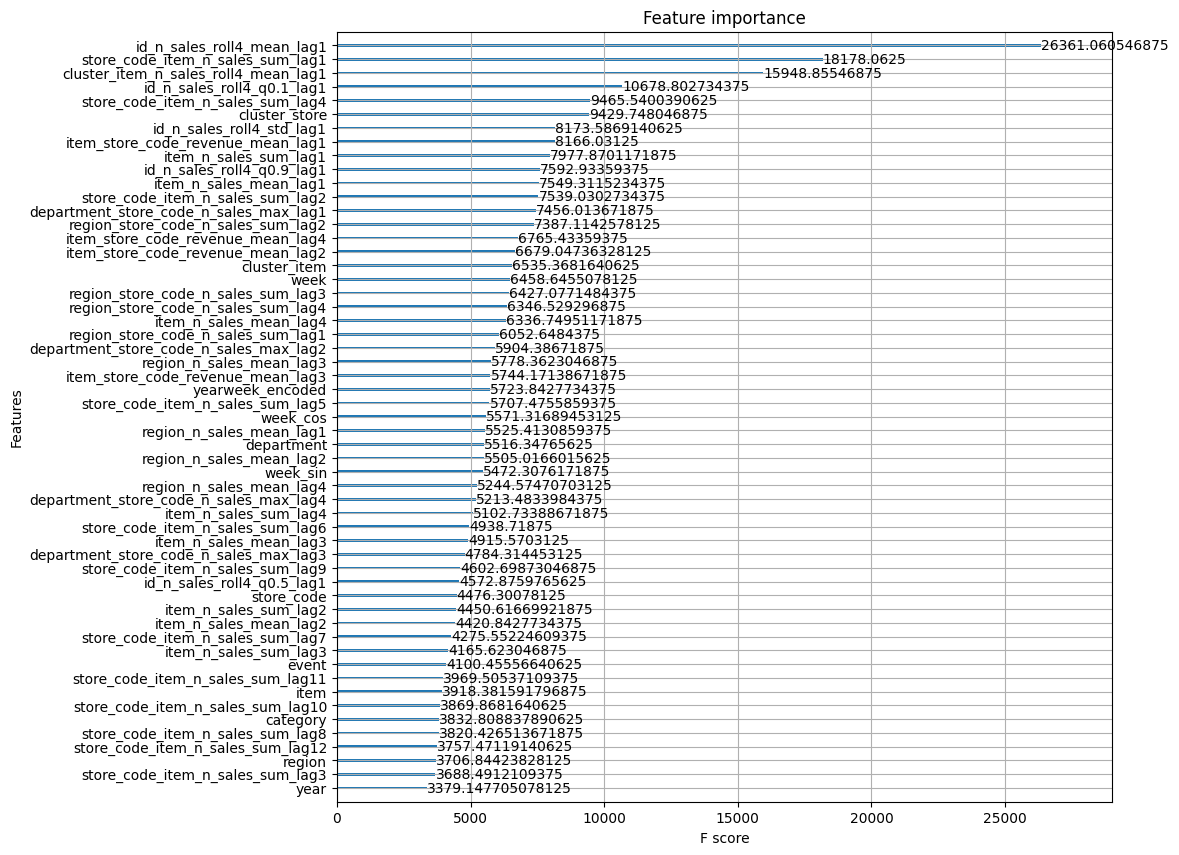

In [124]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_4, importance_type = "gain", ax = ax)

In [125]:
Y_train_4_predict = model_4.predict(X_train_4)
Y_test_4_predict = model_4.predict(X_test_4)

rmse_train_4 = np.sqrt(
    mean_squared_error(
        y_true = y_train_4,
        y_pred = Y_train_4_predict
    )
)

rmse_test_4 = np.sqrt(
    mean_squared_error(
        y_true = y_test_4,
        y_pred = Y_test_4_predict
    )
)

rmse_train_4= str(round(rmse_train_4, 3))
rmse_test_4 = str(round(rmse_test_4, 3))

In [126]:

# Predicciones
Y_train_4_predict = model_4.predict(X_train_4)
Y_test_4_predict  = model_4.predict(X_test_4)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_4 = smape(y_train_4, Y_train_4_predict)
smape_test_4  = smape(y_test_4,  Y_test_4_predict)

smape_train_4 = str(round(smape_train_4, 3))
smape_test_4  = str(round(smape_test_4, 3))

Modelo hace 3 periodos

In [127]:
model_3 = xgb.XGBRegressor(
    n_estimators=2000,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175,
    early_stopping_rounds=20, 
)

In [128]:
model_3.fit(
    X_train, y_train,
    eval_set=[(X_train_3, y_train_3), (X_test_3, y_test_3)]
)

[0]	validation_0-rmse:11.88382	validation_1-rmse:8.73207
[1]	validation_0-rmse:11.78341	validation_1-rmse:8.66585
[2]	validation_0-rmse:11.69061	validation_1-rmse:8.60408
[3]	validation_0-rmse:11.60008	validation_1-rmse:8.54440
[4]	validation_0-rmse:11.51567	validation_1-rmse:8.48262
[5]	validation_0-rmse:11.43344	validation_1-rmse:8.43435
[6]	validation_0-rmse:11.35225	validation_1-rmse:8.38448
[7]	validation_0-rmse:11.27513	validation_1-rmse:8.33709
[8]	validation_0-rmse:11.20107	validation_1-rmse:8.29087
[9]	validation_0-rmse:11.13042	validation_1-rmse:8.24814
[10]	validation_0-rmse:11.05997	validation_1-rmse:8.21235
[11]	validation_0-rmse:10.99426	validation_1-rmse:8.17294
[12]	validation_0-rmse:10.93037	validation_1-rmse:8.13964
[13]	validation_0-rmse:10.86905	validation_1-rmse:8.10355
[14]	validation_0-rmse:10.81042	validation_1-rmse:8.07231
[15]	validation_0-rmse:10.75108	validation_1-rmse:8.03935
[16]	validation_0-rmse:10.69396	validation_1-rmse:8.01063
[17]	validation_0-rmse:1

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.95
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'rmse'


### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

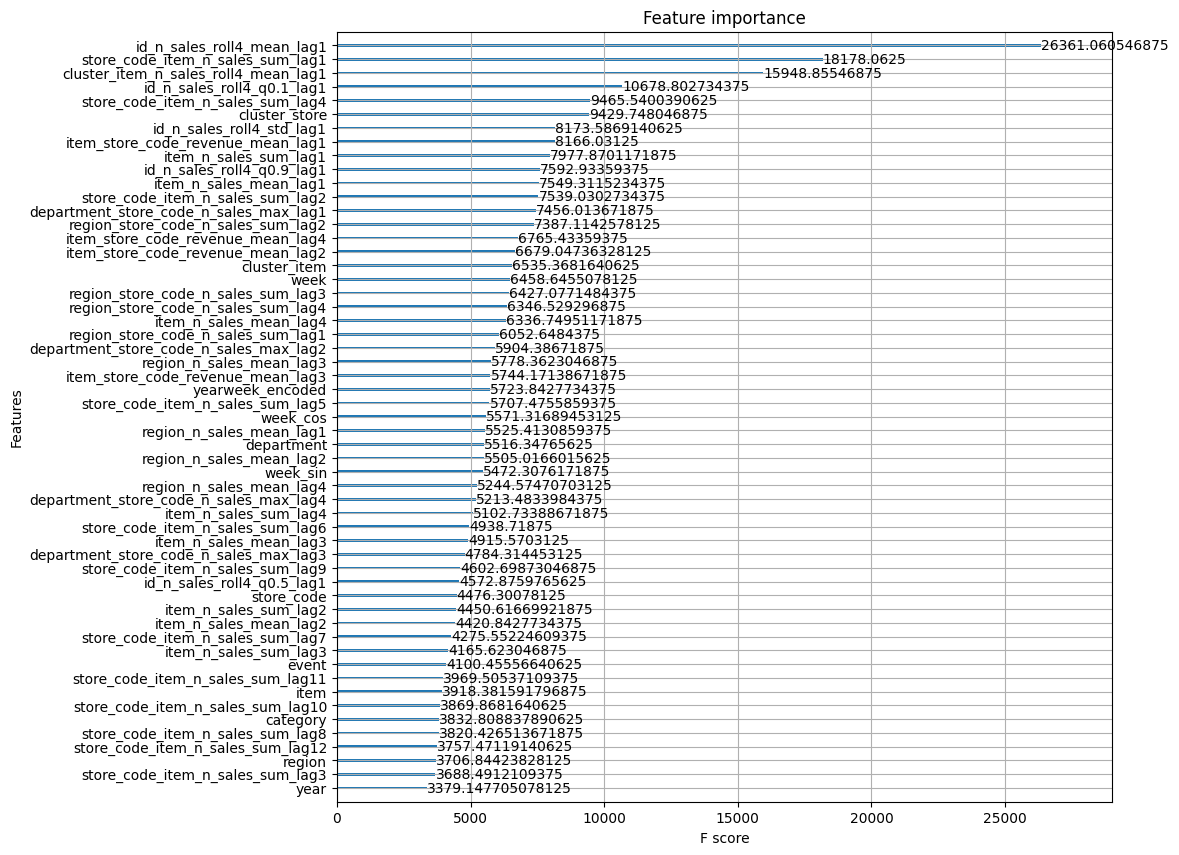

In [129]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_3, importance_type = "gain", ax = ax)

In [130]:
Y_train_3_predict = model_3.predict(X_train_3)
Y_test_3_predict = model_3.predict(X_test_3)

rmse_train_3 = np.sqrt(
    mean_squared_error(
        y_true = y_train_3,
        y_pred = Y_train_3_predict
    )
)

rmse_test_3 = np.sqrt(
    mean_squared_error(
        y_true = y_test_3,
        y_pred = Y_test_3_predict
    )
)

rmse_train_3= str(round(rmse_train_3, 3))
rmse_test_3 = str(round(rmse_test_3, 3))

In [131]:

# Predicciones
Y_train_3_predict = model_3.predict(X_train_3)
Y_test_3_predict  = model_3.predict(X_test_3)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_3 = smape(y_train_3, Y_train_3_predict)
smape_test_3  = smape(y_test_3,  Y_test_3_predict)

smape_train_3 = str(round(smape_train_3, 3))
smape_test_3  = str(round(smape_test_3, 3))

Modelo hace 2 periodos

In [132]:
model_2 = xgb.XGBRegressor(
    n_estimators=2000,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175,
    early_stopping_rounds=20, 
)

In [133]:
model_2.fit(
    X_train, y_train,
    eval_set=[(X_train_2, y_train_2), (X_test_2, y_test_2)]
)

[0]	validation_0-rmse:11.67188	validation_1-rmse:8.60268
[1]	validation_0-rmse:11.57403	validation_1-rmse:8.53045
[2]	validation_0-rmse:11.48360	validation_1-rmse:8.47156
[3]	validation_0-rmse:11.39533	validation_1-rmse:8.40961
[4]	validation_0-rmse:11.31289	validation_1-rmse:8.34830
[5]	validation_0-rmse:11.23277	validation_1-rmse:8.28818
[6]	validation_0-rmse:11.15364	validation_1-rmse:8.22971
[7]	validation_0-rmse:11.07847	validation_1-rmse:8.16863
[8]	validation_0-rmse:11.00630	validation_1-rmse:8.11336
[9]	validation_0-rmse:10.93744	validation_1-rmse:8.06355
[10]	validation_0-rmse:10.86893	validation_1-rmse:8.01133
[11]	validation_0-rmse:10.80487	validation_1-rmse:7.96552
[12]	validation_0-rmse:10.74266	validation_1-rmse:7.92232
[13]	validation_0-rmse:10.68298	validation_1-rmse:7.88214
[14]	validation_0-rmse:10.62596	validation_1-rmse:7.83915
[15]	validation_0-rmse:10.56832	validation_1-rmse:7.80302
[16]	validation_0-rmse:10.51281	validation_1-rmse:7.76170
[17]	validation_0-rmse:1

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.95
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'rmse'


### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

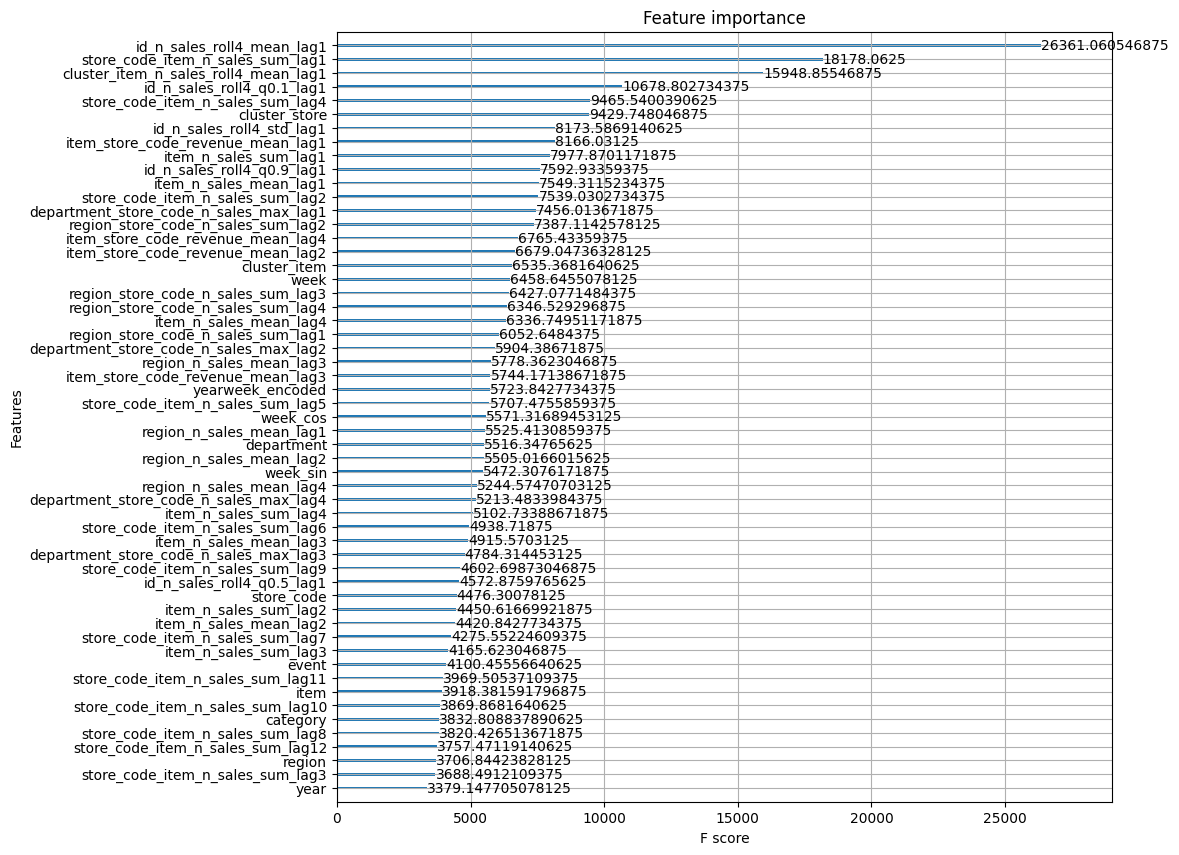

In [134]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_2, importance_type = "gain", ax = ax)

In [135]:
Y_train_2_predict = model_2.predict(X_train_2)
Y_test_2_predict = model_2.predict(X_test_2)

rmse_train_2 = np.sqrt(
    mean_squared_error(
        y_true = y_train_2,
        y_pred = Y_train_2_predict
    )
)

rmse_test_2 = np.sqrt(
    mean_squared_error(
        y_true = y_test_2,
        y_pred = Y_test_2_predict
    )
)

rmse_train_2= str(round(rmse_train_2, 3))
rmse_test_2 = str(round(rmse_test_2, 3))

In [136]:

# Predicciones
Y_train_2_predict = model_2.predict(X_train_2)
Y_test_2_predict  = model_2.predict(X_test_2)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_2 = smape(y_train_2, Y_train_2_predict)
smape_test_2  = smape(y_test_2,  Y_test_2_predict)

smape_train_2 = str(round(smape_train_2, 3))
smape_test_2  = str(round(smape_test_2, 3))

Modelo hace 1 periodo

In [137]:
model_1 = xgb.XGBRegressor(
    n_estimators=2000,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175,
    early_stopping_rounds=20, 
)

In [138]:
model_1.fit(
    X_train, y_train,
    eval_set=[(X_train_1, y_train_1), (X_test_1, y_test_1)]
)

[0]	validation_0-rmse:11.52400	validation_1-rmse:7.88309
[1]	validation_0-rmse:11.42745	validation_1-rmse:7.81877
[2]	validation_0-rmse:11.33795	validation_1-rmse:7.76400
[3]	validation_0-rmse:11.25080	validation_1-rmse:7.69984
[4]	validation_0-rmse:11.16927	validation_1-rmse:7.64328
[5]	validation_0-rmse:11.09013	validation_1-rmse:7.59145
[6]	validation_0-rmse:11.01183	validation_1-rmse:7.54372
[7]	validation_0-rmse:10.93760	validation_1-rmse:7.49693
[8]	validation_0-rmse:10.86583	validation_1-rmse:7.45458
[9]	validation_0-rmse:10.79778	validation_1-rmse:7.41029
[10]	validation_0-rmse:10.73037	validation_1-rmse:7.36776
[11]	validation_0-rmse:10.66738	validation_1-rmse:7.32884
[12]	validation_0-rmse:10.60580	validation_1-rmse:7.28879
[13]	validation_0-rmse:10.54698	validation_1-rmse:7.25098
[14]	validation_0-rmse:10.49072	validation_1-rmse:7.21868
[15]	validation_0-rmse:10.43383	validation_1-rmse:7.18987
[16]	validation_0-rmse:10.37921	validation_1-rmse:7.15135
[17]	validation_0-rmse:1

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.95
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'rmse'


### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

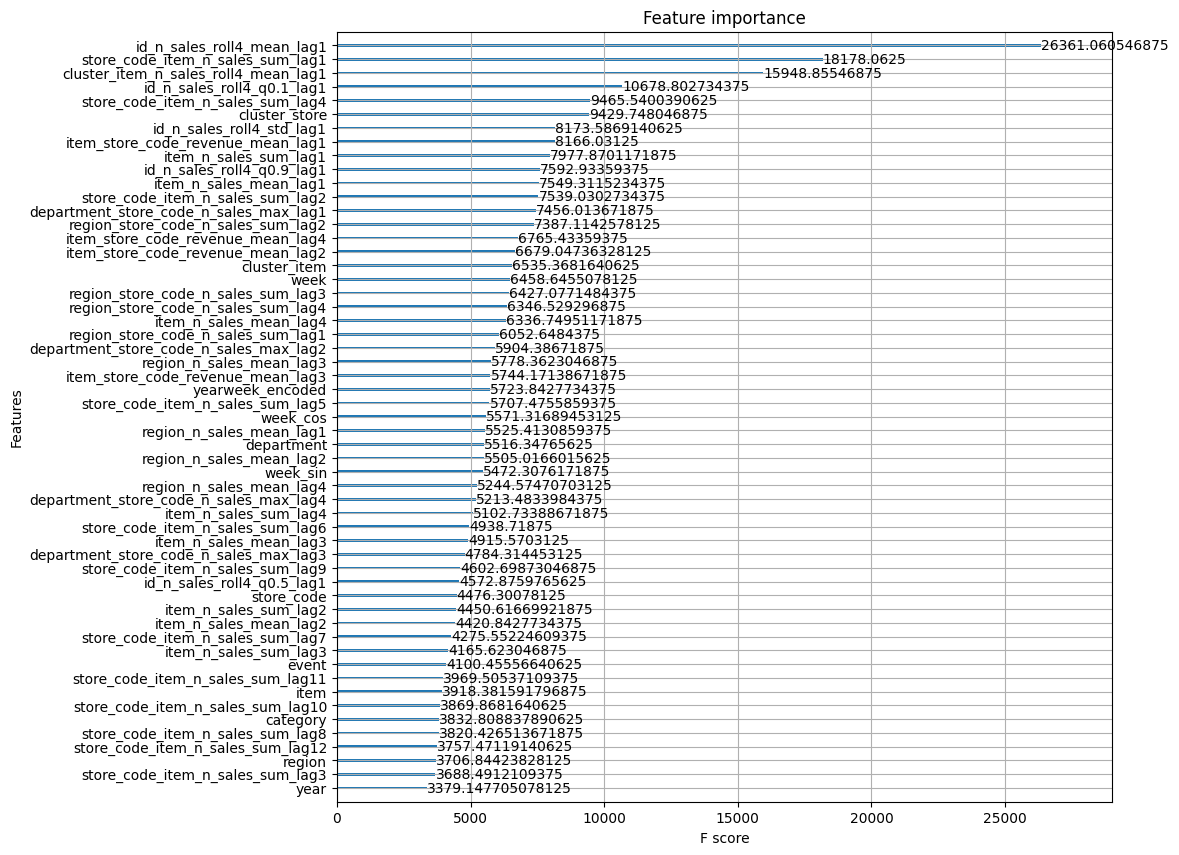

In [139]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_1, importance_type = "gain", ax = ax)

In [140]:
Y_train_1_predict = model_1.predict(X_train_1)
Y_test_1_predict = model_1.predict(X_test_1)

rmse_train_1 = np.sqrt(
    mean_squared_error(
        y_true = y_train_1,
        y_pred = Y_train_1_predict
    )
)

rmse_test_1 = np.sqrt(
    mean_squared_error(
        y_true = y_test_1,
        y_pred = Y_test_1_predict
    )
)

rmse_train_1= str(round(rmse_train_1, 3))
rmse_test_1 = str(round(rmse_test_1, 3))

In [141]:

# Predicciones
Y_train_1_predict = model_1.predict(X_train_1)
Y_test_1_predict  = model_1.predict(X_test_1)

def smape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff  = np.abs(y_true - y_pred)
    # sMAPE en [0, 2]; multiplicamos por 100 para porcentaje [0%, 200%]
    return np.mean(2.0 * diff / np.maximum(denom, epsilon)) * 100.0

smape_train_1 = smape(y_train_1, Y_train_1_predict)
smape_test_1  = smape(y_test_1,  Y_test_1_predict)

smape_train_1 = str(round(smape_train_1, 3))
smape_test_1  = str(round(smape_test_1, 3))

Modelo completo

In [142]:
model_completo = xgb.XGBRegressor(
    n_estimators=2000,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175,
    early_stopping_rounds=20, 
)

In [143]:
model_completo.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

[0]	validation_0-rmse:11.36867	validation_1-rmse:8.32716
[1]	validation_0-rmse:11.27396	validation_1-rmse:8.25732
[2]	validation_0-rmse:11.18619	validation_1-rmse:8.20134
[3]	validation_0-rmse:11.10073	validation_1-rmse:8.13523
[4]	validation_0-rmse:11.02071	validation_1-rmse:8.07992
[5]	validation_0-rmse:10.94315	validation_1-rmse:8.02757
[6]	validation_0-rmse:10.86646	validation_1-rmse:7.97468
[7]	validation_0-rmse:10.79368	validation_1-rmse:7.92286
[8]	validation_0-rmse:10.72330	validation_1-rmse:7.87837
[9]	validation_0-rmse:10.65664	validation_1-rmse:7.83705
[10]	validation_0-rmse:10.59068	validation_1-rmse:7.79093
[11]	validation_0-rmse:10.52897	validation_1-rmse:7.75101
[12]	validation_0-rmse:10.46866	validation_1-rmse:7.71066
[13]	validation_0-rmse:10.41097	validation_1-rmse:7.67702
[14]	validation_0-rmse:10.35599	validation_1-rmse:7.64022
[15]	validation_0-rmse:10.30044	validation_1-rmse:7.60281
[16]	validation_0-rmse:10.24697	validation_1-rmse:7.56591
[17]	validation_0-rmse:1

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.95
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'rmse'


### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

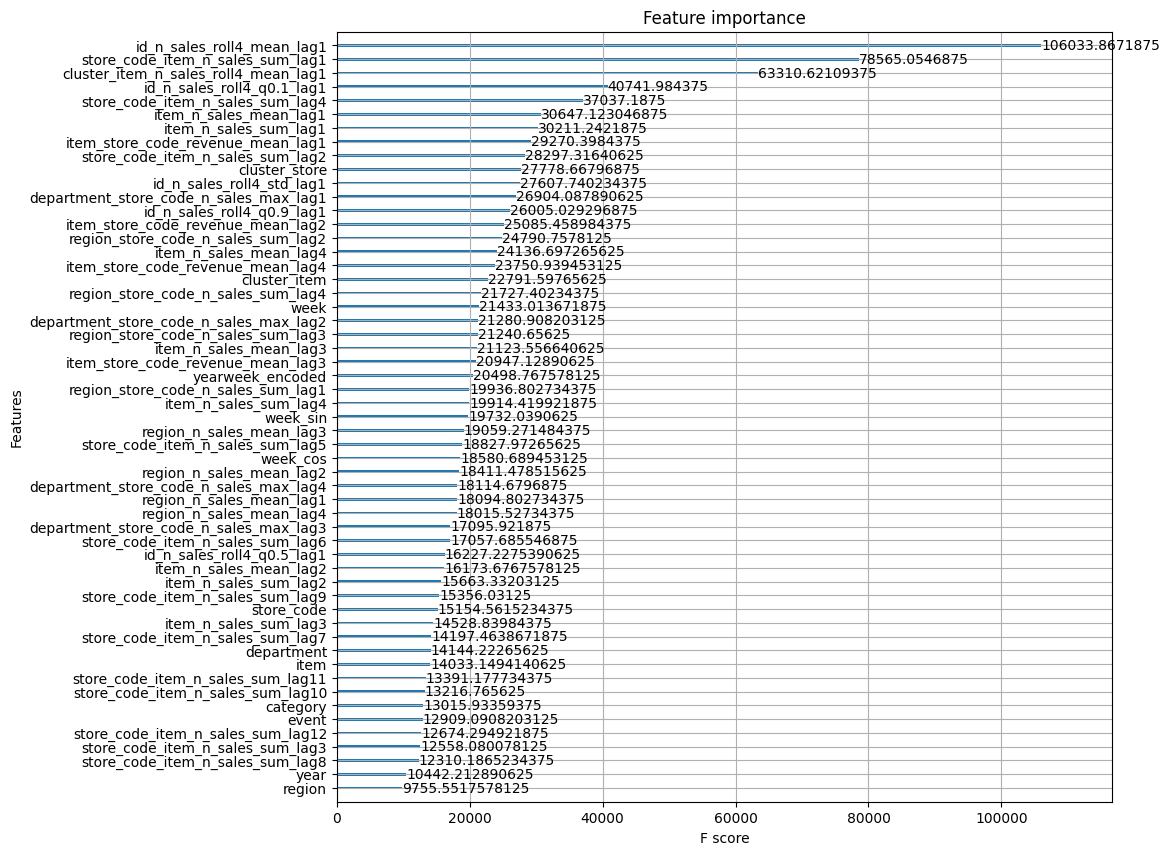

In [144]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model_completo, importance_type = "gain", ax = ax)

In [145]:
Y_test_predict = model_completo.predict(X_test)
Y_test_predict

array([ -2.206263  ,   0.83454627,   2.9172862 , ...,   1.5653088 ,
        -2.9107094 , -11.170972  ], shape=(30490,), dtype=float32)

In [146]:
X_test = X_test.reset_index()

In [147]:
X_test = X_test.set_index(["id", "yearweek", "date", "avg_sell_price"])

### Medicion RMSE

In [148]:
Y_train_predict = model_completo.predict(X_train)
Y_test_predict = model_completo.predict(X_test)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = y_train,
        y_pred = Y_train_predict
    )
)

rmse_test = np.sqrt(
    mean_squared_error(
        y_true = y_test,
        y_pred = Y_test_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_test = str(round(rmse_test, 3)).replace(".", "_")

In [149]:
rmse_train

'6_788'

In [150]:
rmse_test

'6_432'

Cálculo RMSE ponderado

In [151]:
rmse_test_4 = float(rmse_test_4)
rmse_test_3 = float(rmse_test_3)
rmse_test_2 = float(rmse_test_2)
rmse_test = float(rmse_test)/100
rmse_test_1 = float(rmse_test_1)

In [152]:
rmse_test_1

4.155

In [153]:
rmse_test_2

4.522

In [154]:
rmse_test_3

4.478

In [155]:
rmse_test_4

4.447

In [216]:
rmse_test/10

6.4319999999999995

In [219]:
RMSE_TOTAL = (rmse_test_1*0.2)+(rmse_test_4*0.15)+(rmse_test_3*0.15)+((rmse_test/10)*0.3)+(rmse_test_2*0.2)

print(RMSE_TOTAL)

5.003749999999999


Error por cada valor

Reconstruimos ventas originales y ventas estimadas completas

In [158]:
df_ventas_origen_copy = df_ventas_origen.copy()

In [159]:
X_test.reset_index(inplace=True)
X_test_1.reset_index(inplace=True)
X_test_2.reset_index(inplace=True)
X_test_3.reset_index(inplace=True)
X_test_4.reset_index(inplace=True)

In [160]:
df_features

,yearweek,id,item,category,department,store_code,region,date,event,cluster_item,...,region_store_code_n_sales_sum_lag2,region_store_code_n_sales_sum_lag3,region_store_code_n_sales_sum_lag4,id_n_sales_roll4_mean_lag1,id_n_sales_roll4_q0.1_lag1,id_n_sales_roll4_q0.5_lag1,id_n_sales_roll4_q0.9_lag1,id_n_sales_roll4_std_lag1,cluster_item_n_sales_roll4_mean_lag1,yearweek_encoded
0,201105,SUPERMARKET_2_342_NYC_1,2168,2,5,3,1,2011-01-31,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.00,0.0
1,201105,ACCESORIES_1_298_PHI_2,289,0,0,8,2,2011-01-31,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.50,0.0
2,201105,ACCESORIES_1_360_PHI_3,351,0,0,9,2,2011-01-31,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.75,0.0
3,201105,ACCESORIES_1_360_PHI_2,351,0,0,8,2,2011-01-31,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,0.0
4,201105,ACCESORIES_1_360_PHI_1,351,0,0,7,2,2011-01-31,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.75,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6692234,201620,HOME_&_GARDEN_2_014_NYC_2,1110,1,3,4,1,2016-05-16,0,1,...,0.0,-30878.0,651.0,-0.50,-1.4,0.0,0.0,1.000000,0.00,276.0
6692235,201620,HOME_&_GARDEN_2_014_NYC_1,1110,1,3,3,1,2016-05-16,0,1,...,0.0,-31646.0,1095.0,-0.25,-0.7,0.0,0.0,0.500000,0.00,276.0
6692236,201620,HOME_&_GARDEN_2_014_BOS_3,1110,1,3,2,0,2016-05-16,0,1,...,0.0,-25511.0,-1977.0,0.00,-0.7,0.0,0.7,0.816497,0.00,276.0
6692237,201620,HOME_&_GARDEN_2_021_NYC_1,1117,1,3,3,1,2016-05-16,0,1,...,0.0,-31646.0,1095.0,0.00,0.0,0.0,0.0,0.000000,0.00,276.0


In [161]:
Y_test_predict

array([ -2.206263  ,   0.83454627,   2.9172862 , ...,   1.5653088 ,
        -2.9107094 , -11.170972  ], shape=(30490,), dtype=float32)

In [162]:
X_test["diff_n_sales_pred"] = np.asarray(Y_test_predict).ravel()
X_test["diff_n_sales_true"] = np.asarray(y_test).ravel()
X_test_1["diff_n_sales_pred"] = np.asarray(Y_test_1_predict).ravel()
X_test_1["diff_n_sales_true"] = np.asarray(y_test_1).ravel()
X_test_2["diff_n_sales_pred"] = np.asarray(Y_test_2_predict).ravel()
X_test_2["diff_n_sales_true"] = np.asarray(y_test_2).ravel()
X_test_3["diff_n_sales_pred"] = np.asarray(Y_test_3_predict).ravel()
X_test_3["diff_n_sales_true"] = np.asarray(y_test_3).ravel()
X_test_4["diff_n_sales_pred"] = np.asarray(Y_test_4_predict).ravel()
X_test_4["diff_n_sales_true"] = np.asarray(y_test_4).ravel()

In [163]:
X_test["yearweek"] = X_test["yearweek"].astype(int)
X_test["id_yearweek"] = X_test["id"].astype(str) + "_" + X_test["yearweek"].astype(str)
X_test_1["yearweek"] = X_test_1["yearweek"].astype(int)
X_test_1["id_yearweek"] = X_test_1["id"].astype(str) + "_" + X_test_1["yearweek"].astype(str)
X_test_2["yearweek"] = X_test_2["yearweek"].astype(int)
X_test_2["id_yearweek"] = X_test_2["id"].astype(str) + "_" + X_test_2["yearweek"].astype(str)
X_test_3["yearweek"] = X_test_3["yearweek"].astype(int)
X_test_3["id_yearweek"] = X_test_3["id"].astype(str) + "_" + X_test_3["yearweek"].astype(str)
X_test_4["yearweek"] = X_test_4["yearweek"].astype(int)
X_test_4["id_yearweek"] = X_test_4["id"].astype(str) + "_" + X_test_4["yearweek"].astype(str)
df_ventas_origen["id_yearweek"] = df_ventas_origen["id"].astype(str) + "_" + df_ventas_origen["yearweek"].astype(str)

In [164]:
# ordenar por id y fecha (usa mergesort para estabilidad)
df_ventas_origen_copy = df_ventas_origen_copy.sort_values(["date"])

# lag 1 dentro de cada id, respetando el orden por fecha
df_ventas_origen_copy["n_sales_lag1"] = (
    df_ventas_origen_copy.groupby("id", sort=False)["n_sales"].shift(1)
)

# clave para el merge
df_ventas_origen_copy["id_yearweek"] = (
    df_ventas_origen_copy["id"].astype(str) + "_" + df_ventas_origen_copy["yearweek"].astype(str)
)
base = df_ventas_origen_copy[["id_yearweek","n_sales_lag1"]]

# merge 0
X_test = X_test.copy().sort_values(["id","yearweek"])
X_test["id_yearweek"] = X_test["id"].astype(str) + "_" + X_test["yearweek"].astype(str)
X_test = X_test.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales_lag1":"n_sales_base_lag1"}
)

# merge 1
X_test_1 = X_test_1.copy().sort_values(["id","yearweek"])
X_test_1["id_yearweek"] = X_test_1["id"].astype(str) + "_" + X_test_1["yearweek"].astype(str)
X_test_1 = X_test_1.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales_lag1":"n_sales_base_lag1"}
)

# merge 2
X_test_2 = X_test_2.copy().sort_values(["id","yearweek"])
X_test_2["id_yearweek"] = X_test_2["id"].astype(str) + "_" + X_test_2["yearweek"].astype(str)
X_test_2 = X_test_2.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales_lag1":"n_sales_base_lag1"}
)

# merge 3
X_test_3 = X_test_3.copy().sort_values(["id","yearweek"])
X_test_3["id_yearweek"] = X_test_3["id"].astype(str) + "_" + X_test_3["yearweek"].astype(str)
X_test_3 = X_test_3.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales_lag1":"n_sales_base_lag1"}
)

# merge 4
X_test_4 = X_test_4.copy().sort_values(["id","yearweek"])
X_test_4["id_yearweek"] = X_test_4["id"].astype(str) + "_" + X_test_4["yearweek"].astype(str)
X_test_4 = X_test_4.merge(base, on="id_yearweek", how="left").rename(
    columns={"n_sales_lag1":"n_sales_base_lag1"}
)

In [165]:
X_test_1

,yearweek,id,date,avg_sell_price,item,category,department,store_code,region,event,...,id_n_sales_roll4_q0.1_lag1,id_n_sales_roll4_q0.5_lag1,id_n_sales_roll4_q0.9_lag1,id_n_sales_roll4_std_lag1,cluster_item_n_sales_roll4_mean_lag1,yearweek_encoded,diff_n_sales_pred,diff_n_sales_true,id_yearweek,n_sales_base_lag1
0,201603,ACCESORIES_1_001_BOS_1,2016-01-18,10.9858,0,0,0,0,0,0,...,-2.8,0.0,2.1,2.872281,3.50,259.0,1.336782,2.0,ACCESORIES_1_001_BOS_1_201603,0.0
1,201603,ACCESORIES_1_001_BOS_2,2016-01-18,10.9858,0,0,0,1,0,0,...,-2.5,1.0,2.4,2.986079,4.00,259.0,0.831088,0.0,ACCESORIES_1_001_BOS_2_201603,4.0
2,201603,ACCESORIES_1_001_BOS_3,2016-01-18,10.9858,0,0,0,2,0,0,...,-4.0,-3.5,4.7,5.852350,6.00,259.0,2.665401,1.0,ACCESORIES_1_001_BOS_3_201603,2.0
3,201603,ACCESORIES_1_001_NYC_1,2016-01-18,10.9858,0,0,0,3,1,0,...,-2.7,-0.5,1.7,2.380476,2.50,259.0,0.434031,1.0,ACCESORIES_1_001_NYC_1_201603,5.0
4,201603,ACCESORIES_1_001_NYC_2,2016-01-18,10.9858,0,0,0,4,1,0,...,-3.5,1.5,3.0,3.774917,1.00,259.0,-1.741794,-1.0,ACCESORIES_1_001_NYC_2_201603,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30473,201603,SUPERMARKET_3_827_NYC_3,2016-01-18,1.2000,3048,2,6,5,1,0,...,-13.4,-3.0,17.2,16.921387,6.50,259.0,-2.779622,9.0,SUPERMARKET_3_827_NYC_3_201603,35.0
30474,201603,SUPERMARKET_3_827_NYC_4,2016-01-18,1.2000,3048,2,6,6,1,0,...,0.0,0.0,0.0,0.000000,8.75,259.0,3.902131,0.0,SUPERMARKET_3_827_NYC_4_201603,0.0
30475,201603,SUPERMARKET_3_827_PHI_1,2016-01-18,1.2000,3048,2,6,7,2,0,...,-12.2,-4.0,11.2,13.000000,6.75,259.0,3.400853,-1.0,SUPERMARKET_3_827_PHI_1_201603,18.0
30476,201603,SUPERMARKET_3_827_PHI_2,2016-01-18,1.2000,3048,2,6,8,2,0,...,-0.8,2.5,11.4,7.325754,2.50,259.0,-10.552662,0.0,SUPERMARKET_3_827_PHI_2_201603,24.0


In [166]:
X_test["ventas_reales"] = X_test["n_sales_base_lag1"] + X_test["diff_n_sales_true"]
X_test["ventas_predict"] = X_test["n_sales_base_lag1"] + X_test["diff_n_sales_pred"]
X_test_1["ventas_reales"] = X_test_1["n_sales_base_lag1"] + X_test_1["diff_n_sales_true"]
X_test_1["ventas_predict"] = X_test_1["n_sales_base_lag1"] + X_test_1["diff_n_sales_pred"]
X_test_2["ventas_reales"] = X_test_2["n_sales_base_lag1"] + X_test_2["diff_n_sales_true"]
X_test_2["ventas_predict"] = X_test_2["n_sales_base_lag1"] + X_test_2["diff_n_sales_pred"]
X_test_3["ventas_reales"] = X_test_3["n_sales_base_lag1"] + X_test_3["diff_n_sales_true"]
X_test_3["ventas_predict"] = X_test_3["n_sales_base_lag1"] + X_test_3["diff_n_sales_pred"]
X_test_4["ventas_reales"] = X_test_4["n_sales_base_lag1"] + X_test_4["diff_n_sales_true"]
X_test_4["ventas_predict"] = X_test_4["n_sales_base_lag1"] + X_test_4["diff_n_sales_pred"]

In [167]:
X_test = X_test[["id", "item", "yearweek", "ventas_reales", "ventas_predict"]]
X_test_1 = X_test_1[["id", "item", "yearweek", "ventas_reales", "ventas_predict"]]
X_test_2 = X_test_2[["id", "item", "yearweek", "ventas_reales", "ventas_predict"]]
X_test_3 = X_test_3[["id", "item", "yearweek", "ventas_reales", "ventas_predict"]]
X_test_4 = X_test_4[["id", "item", "yearweek", "ventas_reales", "ventas_predict"]]

In [168]:
X_test["residuo"] = X_test["ventas_reales"] - X_test["ventas_predict"]
X_test_1["residuo"] = X_test_1["ventas_reales"] - X_test_1["ventas_predict"]
X_test_2["residuo"] = X_test_2["ventas_reales"] - X_test_2["ventas_predict"]
X_test_3["residuo"] = X_test_3["ventas_reales"] - X_test_3["ventas_predict"]
X_test_4["residuo"] = X_test_4["ventas_reales"] - X_test_4["ventas_predict"]

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_17324\1764419375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_1["residuo"] = X_test_1["ventas_reales"] - X_test_1["ventas_predict"]


In [169]:
rmse_por_id = (
    X_test.dropna(subset=["ventas_reales","ventas_predict"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_1 = (
    X_test_1.dropna(subset=["ventas_reales","ventas_predict"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_2 = (
    X_test_2.dropna(subset=["ventas_reales","ventas_predict"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_3 = (
    X_test_3.dropna(subset=["ventas_reales","ventas_predict"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

rmse_por_id_4 = (
    X_test_4.dropna(subset=["ventas_reales","ventas_predict"])
          .groupby("id")["residuo"]
          .apply(lambda r: np.sqrt(np.mean(r**2)))
          .rename("rmse")
)

In [170]:
def smape(df):
    eps = 1e-8
    return (
        (2 * (df['ventas_reales'] - df['ventas_predict']).abs()) /
        (df['ventas_reales'].abs() + df['ventas_predict'].abs()).clip(lower=eps)
    ).mean() * 100

smape_scores = [
    smape(X_test),
    smape(X_test_1),
    smape(X_test_2),
    smape(X_test_3),
    smape(X_test_4)
]

print("SMAPE por split:", [round(s, 3) for s in smape_scores])
print("SMAPE promedio:", round(sum(smape_scores) / len(smape_scores), 3))

SMAPE por split: [np.float64(68.358), np.float64(77.275), np.float64(78.205), np.float64(78.223), np.float64(80.534)]
SMAPE promedio: 76.519


DF de los errores medios por id

In [171]:
rmse_por_id = rmse_por_id.rename_axis("id").reset_index(name="rmse")
rmse_por_id_1 = rmse_por_id_1.rename_axis("id").reset_index(name="rmse_1")
rmse_por_id_2 = rmse_por_id_2.rename_axis("id").reset_index(name="rmse_2")
rmse_por_id_3 = rmse_por_id_3.rename_axis("id").reset_index(name="rmse_3")
rmse_por_id_4 = rmse_por_id_4.rename_axis("id").reset_index(name="rmse_4")

In [172]:
from functools import reduce
import pandas as pd

dfs = [rmse_por_id, rmse_por_id_1, rmse_por_id_2, rmse_por_id_3, rmse_por_id_4]

rmse_por_id = reduce(
    lambda left, right: pd.merge(left, right, on="id", how="outer"),
    dfs
).sort_values("id").reset_index(drop=True)

In [173]:
# seleccionar las columnas rmse*
rmse_cols = [c for c in rmse_por_id.columns if c.startswith('rmse')]

# (opcional) asegurar que sean numéricas
rmse_por_id[rmse_cols] = rmse_por_id[rmse_cols].apply(pd.to_numeric, errors='coerce')

# media por fila (ignora NaN)
rmse_por_id["rmse_mean"] = rmse_por_id[rmse_cols].mean(axis=1)

In [174]:
rmse_por_id = rmse_por_id[["id", "rmse_mean"]]

In [175]:
rmse_por_id

,id,rmse_mean
0,ACCESORIES_1_001_BOS_1,1.006209
1,ACCESORIES_1_001_BOS_2,1.031386
2,ACCESORIES_1_001_BOS_3,1.477416
3,ACCESORIES_1_001_NYC_1,2.073110
4,ACCESORIES_1_001_NYC_2,2.703180
...,...,...
30485,SUPERMARKET_3_827_NYC_3,5.298480
30486,SUPERMARKET_3_827_NYC_4,4.934147
30487,SUPERMARKET_3_827_PHI_1,9.285024
30488,SUPERMARKET_3_827_PHI_2,7.789934


In [ ]:
rmse_por_id.to_parquet('rmse_por_id.parquet', engine='pyarrow', index=False, compression='snappy')

## 10. Creacion de fichero para visualizacion

In [177]:
X_train_pred = X_train_pred.reset_index()

In [178]:
X_train_pred = X_train_pred.set_index(["yearweek", "id", "date","avg_sell_price"])

In [179]:
X_train_pred

item  category  \
yearweek id                      date       avg_sell_price                   
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760          2168         2   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461           289         0   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239          351         0   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096          351         0   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476          351         0   
...                                                          ...       ...   
201616   ACCESORIES_1_381_BOS_2  2016-04-18 0.9310           372         0   
         ACCESORIES_1_381_BOS_1  2016-04-18 0.9310           372         0   
         ACCESORIES_1_379_NYC_4  2016-04-18 2.9792           370         0   
         ACCESORIES_1_379_PHI_1  2016-04-18 2.9792           370         0   
         ACCESORIES_1_381_NYC_1  2016-04-18 0.9310           372         0   

                                                            department  \
yearweek id                      date       avg_sell_price               
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760                   5   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461                   0   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239                  0   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096                  0   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476                  0   
...                                                                ...   
201616   ACCESORIES_1_381_BOS_2  2016-04-18 0.9310                   0   
         ACCESORIES_1_381_BOS_1  2016-04-18 0.9310                   0   
         ACCESORIES_1_379_NYC_4  2016-04-18 2.9792                   0   
         ACCESORIES_1_379_PHI_1  2016-04-18 2.9792                   0   
         ACCESORIES_1_381_NYC_1  2016-04-18 0.9310                   0   

                                                            store_code  \
yearweek id                      date       avg_sell_price               
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760                   3   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461                   8   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239                  9   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096                  8   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476                  7   
...                                                                ...   
201616   ACCESORIES_1_381_BOS_2  2016-04-18 0.9310                   1   
         ACCESORIES_1_381_BOS_1  2016-04-18 0.9310                   0   
         ACCESORIES_1_379_NYC_4  2016-04-18 2.9792                   6   
         ACCESORIES_1_379_PHI_1  2016-04-18 2.9792                   7   
         ACCESORIES_1_381_NYC_1  2016-04-18 0.9310                   3   

                                                            region  event  \
yearweek id                      date       avg_sell_price                  
201105   SUPERMARKET_2_342_NYC_1 2011-01-31 7.1760               1      1   
         ACCESORIES_1_298_PHI_2  2011-01-31 5.5461               2      1   
         ACCESORIES_1_360_PHI_3  2011-01-31 19.7239              2      1   
         ACCESORIES_1_360_PHI_2  2011-01-31 20.1096              2      1   
         ACCESORIES_1_360_PHI_1  2011-01-31 18.2476              2      1   
...                                                            ...    ...   
201616   ACCESORIES_1_381_BOS_2  2016-04-18 0.9310               0      0   
         ACCESORIES_1_381_BOS_1  2016-04-18 0.9310               0      0   
         ACCESORIES_1_379_NYC_4  2016-04-18 2.9792               1      0   
         ACCESORIES_1_379_PHI_1  2016-04-18 2.9792               2      0   
         ACCESORIES_1_381_NYC_1  2016-04-18 0.9310               1      0   

                                                            cluster_item  \
yearweek id                      date    

In [180]:
model = xgb.XGBRegressor(
    n_estimators=1700,        
    learning_rate=0.03,    
    max_depth=10,          
    subsample=0.95,        
    colsample_bytree=0.95,     
    min_child_weight=1,       
    gamma=0,                 
    reg_lambda=0.5,           
    reg_alpha=0,             
    eval_metric="rmse",
    random_state=175
)

In [221]:
X_train_pred.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6570279 entries, ('201105', 'SUPERMARKET_2_342_NYC_1', Timestamp('2011-01-31 00:00:00'), np.float64(7.176)) to ('201616', 'ACCESORIES_1_381_NYC_1', Timestamp('2016-04-18 00:00:00'), np.float64(0.931))
Data columns (total 55 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   item                                    int64  
 1   category                                int64  
 2   department                              int64  
 3   store_code                              int64  
 4   region                                  int64  
 5   event                                   int64  
 6   cluster_item                            int32  
 7   cluster_store                           int32  
 8   year                                    int64  
 9   week                                    int64  
 10  week_sin                                float64
 11  week_cos              

In [181]:
model.fit(
    X_train_pred, y_train_pred
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.95
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [182]:
Y_pred_predict = model.predict(X_pred)
Y_pred_predict

array([ 2.4934645 , -0.36169213,  1.8733245 , ...,  2.7295182 ,
       -0.31125748,  2.1926036 ], shape=(30490,), dtype=float32)

In [183]:
df_ventas_predict_lag1 = df_ventas_origen[df_ventas_origen["date"]==test_weeks]

In [184]:
df_ventas_predict_lag1

,date,id,n_sales,yearweek,avg_sell_price,id_yearweek
273,2016-04-18,ACCESORIES_1_001_BOS_1,4,201616,10.9858,ACCESORIES_1_001_BOS_1_201616
547,2016-04-18,ACCESORIES_1_001_BOS_2,1,201616,10.9858,ACCESORIES_1_001_BOS_2_201616
821,2016-04-18,ACCESORIES_1_001_BOS_3,0,201616,10.9858,ACCESORIES_1_001_BOS_3_201616
1095,2016-04-18,ACCESORIES_1_001_NYC_1,8,201616,11.1454,ACCESORIES_1_001_NYC_1_201616
1369,2016-04-18,ACCESORIES_1_001_NYC_2,10,201616,11.1454,ACCESORIES_1_001_NYC_2_201616
...,...,...,...,...,...,...
8353163,2016-04-18,SUPERMARKET_3_827_NYC_3,38,201616,1.2000,SUPERMARKET_3_827_NYC_3_201616
8353437,2016-04-18,SUPERMARKET_3_827_NYC_4,22,201616,1.2000,SUPERMARKET_3_827_NYC_4_201616
8353711,2016-04-18,SUPERMARKET_3_827_PHI_1,15,201616,1.2000,SUPERMARKET_3_827_PHI_1_201616
8353985,2016-04-18,SUPERMARKET_3_827_PHI_2,12,201616,1.2000,SUPERMARKET_3_827_PHI_2_201616


In [185]:
df_ventas_predict_lag1 = df_ventas_predict_lag1[["id", "n_sales", "avg_sell_price"]]

In [186]:
X_pred.reset_index(inplace=True)

In [187]:
df_prediction = pd.DataFrame({
    'id': X_pred['id'],          # toma el id original
    'Y_pred_predict': Y_pred_predict  # agrega las predicciones
})

In [188]:
df_prediction.reset_index()

,index,id,Y_pred_predict
0,0,SUPERMARKET_2_120_NYC_3,2.493464
1,1,SUPERMARKET_2_120_NYC_4,-0.361692
2,2,SUPERMARKET_2_120_PHI_1,1.873325
3,3,SUPERMARKET_2_120_PHI_2,1.586800
4,4,SUPERMARKET_2_117_BOS_2,-1.734013
...,...,...,...
30485,30485,HOME_&_GARDEN_1_255_BOS_2,-0.341044
30486,30486,HOME_&_GARDEN_1_255_BOS_3,1.069323
30487,30487,HOME_&_GARDEN_1_256_BOS_3,2.729518
30488,30488,HOME_&_GARDEN_1_255_NYC_1,-0.311257


In [189]:
df_prediction = df_prediction.merge(
    df_ventas_predict_lag1[['id', 'n_sales', "avg_sell_price"]],
    on='id',
    how='left'  # usa 'left' para mantener todos los ids de df_prediction
)

In [190]:
df_prediction["ventas"] = df_prediction["Y_pred_predict"] + df_prediction["n_sales"]

In [191]:
df_prediction

,id,Y_pred_predict,n_sales,avg_sell_price,ventas
0,SUPERMARKET_2_120_NYC_3,2.493464,0,3.2640,2.493464
1,SUPERMARKET_2_120_NYC_4,-0.361692,5,3.2640,4.638308
2,SUPERMARKET_2_120_PHI_1,1.873325,8,3.2640,9.873325
3,SUPERMARKET_2_120_PHI_2,1.586800,0,3.2640,1.586800
4,SUPERMARKET_2_117_BOS_2,-1.734013,6,7.1640,4.265987
...,...,...,...,...,...
30485,HOME_&_GARDEN_1_255_BOS_2,-0.341044,5,11.8375,4.658956
30486,HOME_&_GARDEN_1_255_BOS_3,1.069323,2,11.8375,3.069323
30487,HOME_&_GARDEN_1_256_BOS_3,2.729518,5,7.4625,7.729518
30488,HOME_&_GARDEN_1_255_NYC_1,-0.311257,3,11.8375,2.688743


In [192]:
df_prediction = df_prediction[["id", "ventas", "avg_sell_price"]]

In [193]:
df_prediction["n_sales"] = df_prediction["ventas"]

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_17324\275481526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction["n_sales"] = df_prediction["ventas"]


In [194]:
df_prediction.drop(columns="ventas", inplace=True)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_17324\2152357934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction.drop(columns="ventas", inplace=True)


In [195]:
df_prediction["n_sales"] = df_prediction["n_sales"].clip(lower=0)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_17324\2384717976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction["n_sales"] = df_prediction["n_sales"].clip(lower=0)


In [196]:
df_prediction["n_sales"].describe()

count    30490.000000
mean         8.164642
std         17.644952
min          0.000000
25%          1.752345
50%          3.855441
75%          8.222532
max        702.017262
Name: n_sales, dtype: float64

In [197]:
df_prediction["yearweek"] = "201617"
df_prediction["yearweek"] = df_prediction["yearweek"].astype(int)

C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_17324\987313188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction["yearweek"] = "201617"
C:\Users\pablo.giner.eurostar\AppData\Local\Temp\ipykernel_17324\987313188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction["yearweek"] = df_prediction["yearweek"].astype(int)


In [198]:
df_prediction

,id,avg_sell_price,n_sales,yearweek
0,SUPERMARKET_2_120_NYC_3,3.2640,2.493464,201617
1,SUPERMARKET_2_120_NYC_4,3.2640,4.638308,201617
2,SUPERMARKET_2_120_PHI_1,3.2640,9.873325,201617
3,SUPERMARKET_2_120_PHI_2,3.2640,1.586800,201617
4,SUPERMARKET_2_117_BOS_2,7.1640,4.265987,201617
...,...,...,...,...
30485,HOME_&_GARDEN_1_255_BOS_2,11.8375,4.658956,201617
30486,HOME_&_GARDEN_1_255_BOS_3,11.8375,3.069323,201617
30487,HOME_&_GARDEN_1_256_BOS_3,7.4625,7.729518,201617
30488,HOME_&_GARDEN_1_255_NYC_1,11.8375,2.688743,201617


In [199]:
df_prediction["revenue"] = df_prediction["n_sales"] * df_prediction["avg_sell_price"]

In [200]:
df_copy["n_sales"].describe()

count    8.476220e+06
mean     7.750555e+00
std      2.352787e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      7.000000e+00
max      3.976000e+03
Name: n_sales, dtype: float64

In [201]:
df_nuevo = df_copy.merge(
    df_prediction[['id', 'yearweek', 'n_sales']],
    on=['id', 'yearweek'],
    how='left',
    suffixes=('', '_predict')
)

In [202]:
df_nuevo

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,cluster_store,n_sales,revenue,avg_sell_price,year,n_sales_predict
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,2011-01-24,0,0,2,0,0.0,NaN,2011,NaN
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,2011-01-31,1,0,2,0,0.0,NaN,2011,NaN
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,2011-02-07,0,0,2,0,0.0,NaN,2011,NaN
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,2011-02-14,1,0,2,0,0.0,NaN,2011,NaN
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,2011-02-21,0,0,2,0,0.0,NaN,2011,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476215,SUPERMARKET_3_827_PHI_2,3048,2,6,8,2,201620,2016-05-16,0,0,0,0,0.0,1.2,2016,NaN
8476216,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201617,2016-04-25,0,0,2,0,0.0,1.2,2016,10.805123
8476217,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201618,2016-05-02,0,0,2,0,0.0,1.2,2016,NaN
8476218,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201619,2016-05-09,0,0,2,0,0.0,1.2,2016,NaN


In [203]:
df_nuevo['n_sales_predict'] = df_nuevo['n_sales_predict'].fillna(df_nuevo['n_sales'])

In [204]:
df_nuevo['n_sales_predict'].describe()

count    8.476220e+06
mean     7.779924e+00
std      2.354706e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      7.000000e+00
max      3.976000e+03
Name: n_sales_predict, dtype: float64

In [205]:
df_nuevo_copy = df_nuevo.copy()

In [206]:
df_nuevo.drop(columns="n_sales", inplace=True)

In [207]:
df_nuevo["n_sales"] = df_nuevo['n_sales_predict']

In [208]:
df_nuevo.drop(columns="n_sales_predict", inplace=True)

In [209]:
df_nuevo = df_nuevo[["id", "item", "category", "department", "store_code", "region", "yearweek", "avg_sell_price", "event", "cluster_store", "cluster_item", "n_sales", "date", "revenue"]]

In [210]:
df_nuevo

,id,item,category,department,store_code,region,yearweek,avg_sell_price,event,cluster_store,cluster_item,n_sales,date,revenue
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,NaN,0,2,0,0.000000,2011-01-24,0.0
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,NaN,1,2,0,0.000000,2011-01-31,0.0
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,NaN,0,2,0,0.000000,2011-02-07,0.0
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,NaN,1,2,0,0.000000,2011-02-14,0.0
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,NaN,0,2,0,0.000000,2011-02-21,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476215,SUPERMARKET_3_827_PHI_2,3048,2,6,8,2,201620,1.2,0,0,0,0.000000,2016-05-16,0.0
8476216,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201617,1.2,0,2,0,10.805123,2016-04-25,0.0
8476217,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201618,1.2,0,2,0,0.000000,2016-05-02,0.0
8476218,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201619,1.2,0,2,0,0.000000,2016-05-09,0.0


In [211]:
df_prediction_1 = df_nuevo.copy()

In [212]:
df_prediction_1["n_sales"] = round(df_prediction_1["n_sales"],0).astype(int)

In [213]:
df_prediction_1

,id,item,category,department,store_code,region,yearweek,avg_sell_price,event,cluster_store,cluster_item,n_sales,date,revenue
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,NaN,0,2,0,0,2011-01-24,0.0
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,NaN,1,2,0,0,2011-01-31,0.0
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,NaN,0,2,0,0,2011-02-07,0.0
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,NaN,1,2,0,0,2011-02-14,0.0
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,NaN,0,2,0,0,2011-02-21,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476215,SUPERMARKET_3_827_PHI_2,3048,2,6,8,2,201620,1.2,0,0,0,0,2016-05-16,0.0
8476216,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201617,1.2,0,2,0,11,2016-04-25,0.0
8476217,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201618,1.2,0,2,0,0,2016-05-02,0.0
8476218,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,201619,1.2,0,2,0,0,2016-05-09,0.0


In [214]:
df_prediction_1.to_parquet('df_prediction_1', engine='pyarrow', index=False, compression='snappy')

In [215]:
model.save_model("xgb_model_ds_market.json")